In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import scipy

In [2]:
PATH_hh = "E://P5_5_SFT_dynamics//results_visualize//exp_results_hh"
PATH_fb = "E://P5_5_SFT_dynamics//results_visualize//exp_results_ultrafb"

RESPONSE_LIST = ['chosen', 'chosen_initial', 'chosen_selfr', 'chosen_gptsemantic', 'chosen_gptformat',
                 'rejected', 'reject_gptsemantic', 'reject_gptformat',
                 'irr_train', 'irr_test', 'irr_hum',
                 'random_permute', 'random_nonhum',
                 'argmax'
                ]

In [3]:
def read_json_old_exps(file_path,train_test='train'):
    results = {'chosen':[], 'chosen_initial':[], 'chosen_selfr':[], 'chosen_gptsemantic':[], 'chosen_gptformat':[],
                'rejected':[], 'reject_gptsemantic':[], 'reject_gptformat':[],
                'irr_train':[], 'irr_test':[], 'irr_hum':[],
                'random_permute':[], 'random_nonhum':[],
                'argmax':[]}
    
    with open(file_path, 'r') as f:
        for line in f:
            break
    if len(line) < 5000:    # results in new format
        with open(file_path, 'r') as f:
            results = {'chosen':[], 'chosen_initial':[], 'chosen_selfr':[], 'chosen_gptsemantic':[], 'chosen_gptformat':[],
                        'rejected':[], 'reject_gptsemantic':[], 'reject_gptformat':[],
                        'irr_train':[], 'irr_test':[], 'irr_hum':[],
                        'random_permute':[], 'random_nonhum':[],
                        'argmax':[]}    
            for line in f:
                dict_line = json.loads(line.strip('\n'))
                for key in RESPONSE_LIST:
                    if key == 'argmax':
                        true_key = 'argmax_prob_logits'
                    else:
                        true_key = f'logps_eval_prob_{train_test}/{key}'
                    if true_key in dict_line.keys():
                        results[key].append(dict_line[true_key])
                    else:
                        results[key].append(0.01)
    else:                   # results in old format
        with open(file_path, 'r') as f:
            cnt = 0
            for line in f:
                cnt+=1
        line_split = line.split('}{')
        for i in range(len(line_split)):
            if i == 0:
                line_result = line_split[i] + '}'
            elif i==len(line_split)-1:
                line_result = '{' + line_split[i]
            else:
                line_result = '{' + line_split[i] + '}'
            line_json = json.loads(line_result)
            for key in RESPONSE_LIST:
                if key == 'argmax':
                    continue
                results[key].append(line_json[f'logps_eval_prob_{train_test}/{key}'])
    return results

def smooth_path(origin_path, alpha=0.9):
    origin_path_ = np.array(origin_path)
    smoothed_path = np.zeros_like(origin_path_)
    smoothed_path[0] = origin_path_[0]
    for i in range(1, origin_path_.shape[0]):
        smoothed_path[i] = smoothed_path[i-1]*alpha + origin_path_[i]*(1-alpha)
    return smoothed_path

### Figure 1

In [9]:
model ='pythia410m_20240416' #'qwen05_20240419' #
file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
results = read_json_old_exps(file_path)
FIG1_KEYS = ['chosen', 'rejected', 'irr_train', 'irr_test', 'irr_hum','random_permute', 'random_nonhum']

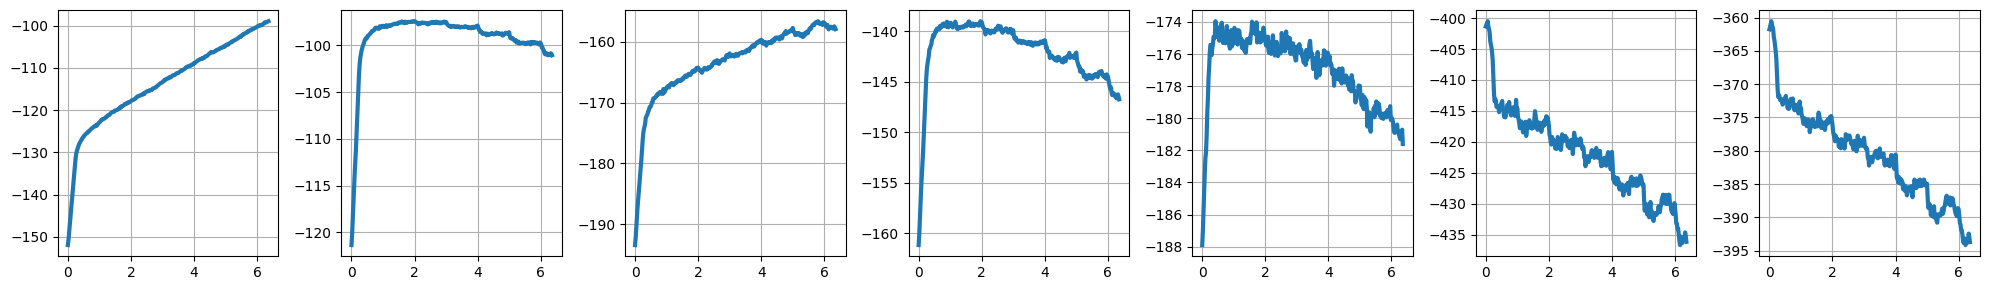

In [10]:
fig, ax = plt.subplots(1,7,figsize=(20,3))
x_axis = np.arange(0,len(results['chosen']))*100/5000
for i in range(7):
    ax[i].plot(x_axis,results[FIG1_KEYS[i]],linewidth=3)
    ax[i].grid(True)
plt.tight_layout()
#save_name = os.path.join('figures','fig1_all_7_curves.pdf')
#plt.savefig(save_name)

### Figure 2

Also generate them for all different models

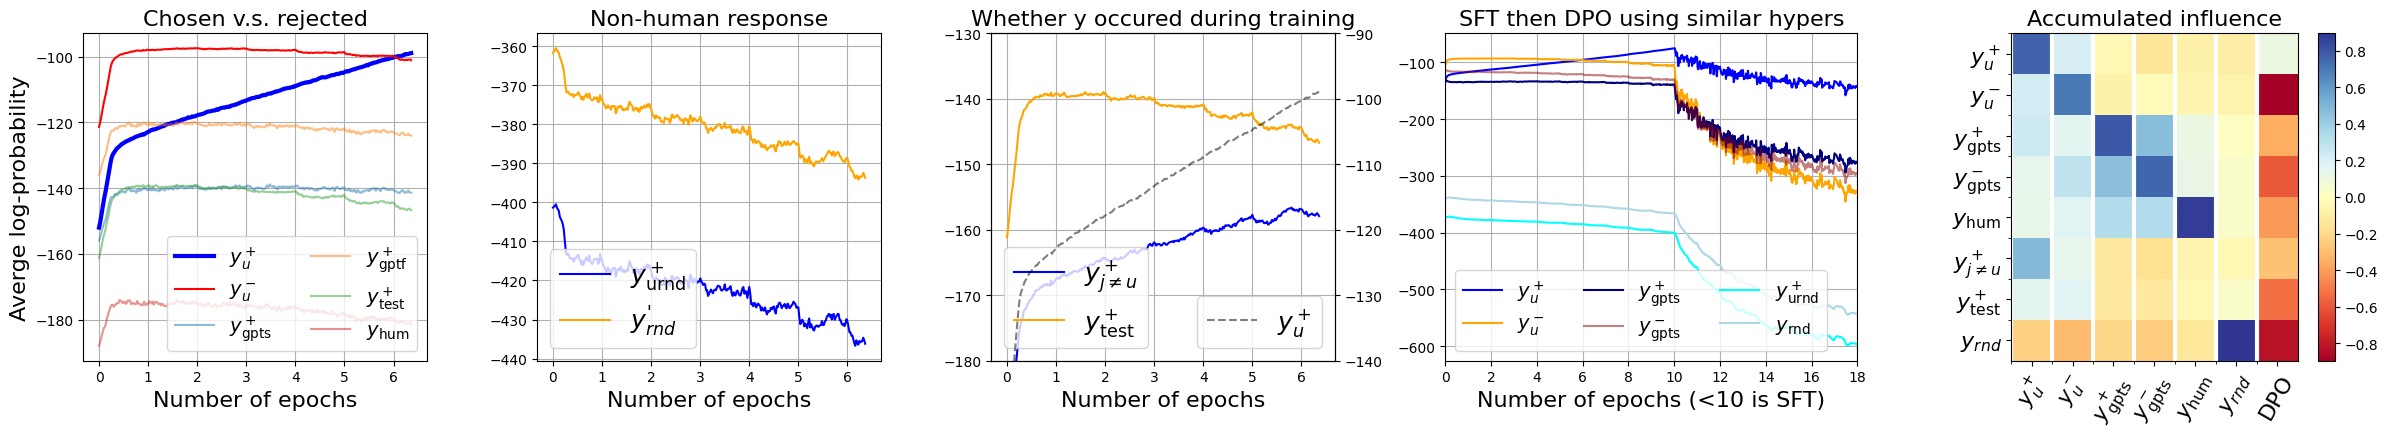

In [44]:
# ======= New Figure 2 for ICLR
PATH = PATH_hh
MODEL_LIST = ['qwen05_20240419', 'pythia410m_20240416', 'pythia1b_20240416','pythia14_20240416','pythia28_20240416']
# model = MODEL_LIST[0]#'qwen05_20240419' # 'pythia410m_20240416' #  
# file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
# results = read_json_old_exps(file_path)
FIG1_KEYS = ['chosen', 'rejected', 'irr_train', 'irr_test', 'irr_hum','random_permute', 'random_nonhum']

model = MODEL_LIST[1]#'qwen05_20240419' # 'pythia410m_20240416' #  
model_name = model.split(' ')[0]
file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
results = read_json_old_exps(file_path)

fig, ax = plt.subplots(1,5,figsize=(24,4.5), gridspec_kw={'width_ratios': [1, 1, 1, 1.2, 1.2]})
x_axis = np.arange(0,len(results['chosen']))*100/5000
OBS_NUM = 400

ax[0].plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', color='blue',linewidth=3)
ax[0].plot(x_axis[:OBS_NUM], results['rejected'][:OBS_NUM], label=r'$y_u^-$',color='red')
ax[0].plot(x_axis[:OBS_NUM], results['chosen_gptsemantic'][:OBS_NUM], label=r'$y_\text{gpts}^+$',alpha=0.5)
ax[0].plot(x_axis[:OBS_NUM], results['chosen_gptformat'][:OBS_NUM], label=r'$y_\text{gptf}^+$',alpha=0.5)
ax[0].plot(x_axis[:OBS_NUM], results['irr_test'][:OBS_NUM], label=r'$y_\text{test}^+$',alpha=0.5)
ax[0].plot(x_axis[:OBS_NUM], results['irr_hum'][:OBS_NUM], label=r'$y_\text{hum}$',alpha=0.5)
ax[0].grid(True)
#ax[0].set_xscale('log')
ax[0].legend(fontsize=14, ncol=2)
ax[0].set_xlabel('Number of epochs',fontsize=16)
ax[0].set_title('Chosen v.s. rejected',fontsize=16)
ax[0].set_ylabel('Averge log-probability',fontsize=16)

ax[1].plot(x_axis[:OBS_NUM], results['random_permute'][:OBS_NUM], label=r'$y_\text{urnd}^+$', color='blue')
ax[1].plot(x_axis[:OBS_NUM], results['random_nonhum'][:OBS_NUM], label=r"$y_{rnd}^'$",color='orange')
ax[1].grid(True)
#ax[1].set_xscale('log')
ax[1].legend(fontsize=18,loc='lower left')
ax[1].set_xlabel('Number of epochs',fontsize=16)
ax[1].set_title('Non-human response',fontsize=16)

ax22 = ax[2].twinx()
ax[2].plot(x_axis[:OBS_NUM], results['irr_train'][:OBS_NUM], label=r'$y_{j\neq u}^+$', color='blue')
ax[2].plot(x_axis[:OBS_NUM], results['irr_test'][:OBS_NUM], label=r"$y_\text{test}^+$",color='orange')
ax22.plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', linestyle='dashed', color='black',alpha=0.5)
#ax22.plot(x_axis[:OBS_NUM], results['rejected'][:OBS_NUM], label=r'$y_u^-$', linestyle='dotted', color='black')
ax[2].grid(True)
#ax[2].set_xscale('log')
ax[2].legend(fontsize=18,loc='lower left')
ax22.legend(fontsize=18,loc='lower right')
ax[2].set_ylim(-180, -130)
ax22.set_ylim(-140, -90)
ax[2].set_xlabel('Number of epochs',fontsize=16)
ax[2].set_title('Whether y occured during training',fontsize=16)

# model = MODEL_LIST[2]#'qwen05_20240419' # 'pythia410m_20240416' #  
# file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
# results = read_json_old_exps(file_path)
# x_axis = np.arange(0,len(results['chosen']))*100/5000

# OBS_NUM = 400
# ax33 = ax[3].twinx()
# ax[3].plot(x_axis[:OBS_NUM], smooth_path(results['irr_test'][:OBS_NUM],alpha=0.5), label=r"$y_\text{test}^+$", color='blue')
# ax33.plot(x_axis[:OBS_NUM], smooth_path(results['irr_hum'][:OBS_NUM],alpha=0.5), label=r"$y_{hum}$",color='orange')
# ax[3].grid(True)
# #ax[3].set_xscale('log')
# ax[3].legend(fontsize=18,loc='lower left')
# ax33.legend(fontsize=18,loc='lower right')
# ax[3].set_xlabel('Number of epochs',fontsize=16)
# ax[3].set_title('Whether y is a dialog response',fontsize=16)

# ========= Last panel

PATH = PATH_hh
MODEL_SEQ = [("dpo_pythia410m", "dpo_pythia410m"),
             ("pythia410m_save_suprej", "dpo_pythia410m_sft_longer"),
             ("qwen05_ep10", "dpo_qwen05_sft10_observeargmax")]
OBS_NUM = -1
X_INTERVAL = 100
j=2
file_path = os.path.join(PATH, MODEL_SEQ[j][0], 'prob_train_metrics.json')
sft_results = read_json_old_exps(file_path)
file_path = os.path.join(PATH, MODEL_SEQ[j][1], 'prob_train_metrics.json')
dpo_results = read_json_old_exps(file_path)
x_axis = np.arange(0,len(sft_results['chosen']+dpo_results['chosen']))*X_INTERVAL/5000
    
ax[3].plot(x_axis, sft_results['chosen'] + dpo_results['chosen'], label=r'$y_u^+$', color='blue')
ax[3].plot(x_axis, sft_results['rejected'] + dpo_results['rejected'], label=r'$y_u^-$',color='orange')
ax[3].plot(x_axis[:OBS_NUM], (sft_results['chosen_gptsemantic'] + dpo_results['chosen_gptsemantic'])[:OBS_NUM], label=r'$y_\text{gpts}^+$',color='navy')
ax[3].plot(x_axis[:OBS_NUM], (sft_results['reject_gptsemantic'] + dpo_results['reject_gptsemantic'])[:OBS_NUM], label=r'$y_\text{gpts}^-$',color='darkred',alpha=0.5)
ax[3].plot(x_axis[:OBS_NUM], smooth_path((sft_results['random_permute']+dpo_results['random_permute'])[:OBS_NUM], 0.9), label=r'$y_\text{urnd}^+$',color='cyan')
ax[3].plot(x_axis[:OBS_NUM], smooth_path((sft_results['random_nonhum']+dpo_results['random_nonhum'])[:OBS_NUM], 0.9), label=r'$y_\text{rnd}$',color='lightblue')
ax[3].grid(True)
ax[3].legend(fontsize=14, ncol=3)
ax[3].set_xlim(0, 18)

ax[3].set_xlabel('Number of epochs (<10 is SFT)',fontsize=16)
ax[3].set_title('SFT then DPO using similar hypers',fontsize=16)


x_labels = ['$y_u^+$',
 '$y_u^-$',
 '$y_\\text{gpts}^+$',
 '$y_\\text{gpts}^-$',
 '$y_\\text{hum}$',
 '$y_{rnd}$',
 'DPO']
y_labels = ['$y_u^+$',
 '$y_u^-$',
 '$y_\\text{gpts}^+$',
 '$y_\\text{gpts}^-$',
 '$y_\\text{hum}$',
 '$y_{j\\neq u}^+$',
 '$y_\\text{test}^+$',
 '$y_{rnd}$']

tmp_res = np.load('tmp_res.npy')
import matplotlib.colors as colors
import matplotlib.patches as patches
pc = ax[4].imshow(tmp_res,norm = colors.CenteredNorm(), cmap='RdYlBu')
ax[4].tick_params(axis='x', labelrotation=60)
ax[4].set_xticks(np.arange(len(x_labels))-.5, minor=True)
ax[4].set_xticks(np.arange(len(x_labels)), labels=x_labels, fontsize=16)
ax[4].set_yticks(np.arange(len(y_labels))-.5, minor=True)
ax[4].set_yticks(np.arange(len(y_labels)), labels=y_labels, fontsize=16)
#ax[4].tick_params(top=False, labeltop=True, bottom=False, labelbottom=False)
ax[4].grid(which="minor", axis='x', color="w", linestyle='-', linewidth=3)
ax[4].set_title('Accumulated influence',fontsize=16)
#cax = ax[4].inset_axes([0.3, 0.07, 0.4, 0.04])
fig.colorbar(pc, ax=ax[4], shrink=1, location='right')
fig.subplots_adjust(hspace=0, wspace=0)

plt.tight_layout()
# save_name = os.path.join('figures',f'fig2_sft_compare_new.pdf')
# plt.savefig(save_name)

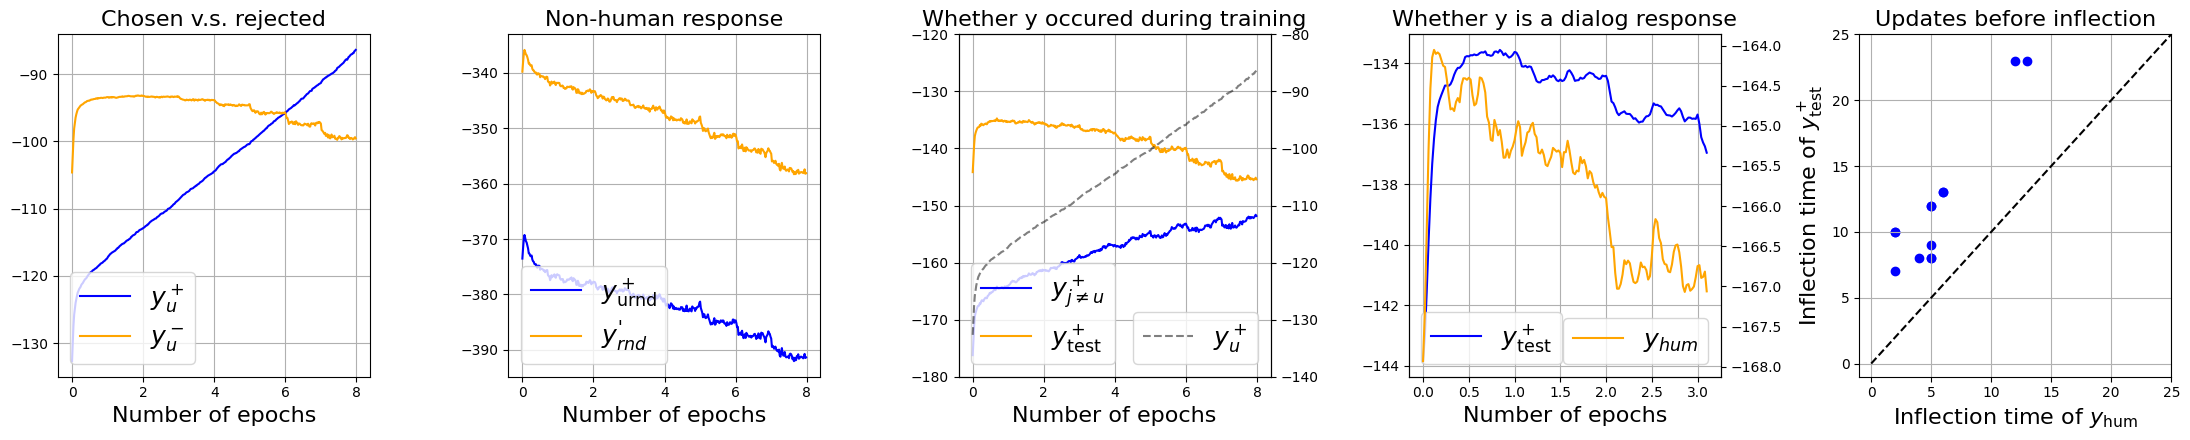

In [36]:
PATH = PATH_hh
MODEL_LIST = ['qwen05_20240419', 'pythia410m_20240416', 'pythia1b_20240416','pythia14_20240416','pythia28_20240416']
# model = MODEL_LIST[0]#'qwen05_20240419' # 'pythia410m_20240416' #  
# file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
# results = read_json_old_exps(file_path)
FIG1_KEYS = ['chosen', 'rejected', 'irr_train', 'irr_test', 'irr_hum','random_permute', 'random_nonhum']

model = MODEL_LIST[0]#'qwen05_20240419' # 'pythia410m_20240416' #  
model_name = model.split(' ')[0]
file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
results = read_json_old_exps(file_path)

fig, ax = plt.subplots(1,5,figsize=(22,4.5))
x_axis = np.arange(0,len(results['chosen']))*100/5000
OBS_NUM = 400

ax[0].plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', color='blue')
ax[0].plot(x_axis[:OBS_NUM], results['rejected'][:OBS_NUM], label=r'$y_u^-$',color='orange')
ax[0].grid(True)
#ax[0].set_xscale('log')
ax[0].legend(fontsize=18, loc='lower left')
ax[0].set_xlabel('Number of epochs',fontsize=16)
ax[0].set_title('Chosen v.s. rejected',fontsize=16)

ax[1].plot(x_axis[:OBS_NUM], results['random_permute'][:OBS_NUM], label=r'$y_\text{urnd}^+$', color='blue')
ax[1].plot(x_axis[:OBS_NUM], results['random_nonhum'][:OBS_NUM], label=r"$y_{rnd}^'$",color='orange')
ax[1].grid(True)
#ax[1].set_xscale('log')
ax[1].legend(fontsize=18,loc='lower left')
ax[1].set_xlabel('Number of epochs',fontsize=16)
ax[1].set_title('Non-human response',fontsize=16)

ax22 = ax[2].twinx()
ax[2].plot(x_axis[:OBS_NUM], results['irr_train'][:OBS_NUM], label=r'$y_{j\neq u}^+$', color='blue')
ax[2].plot(x_axis[:OBS_NUM], results['irr_test'][:OBS_NUM], label=r"$y_\text{test}^+$",color='orange')
ax22.plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', linestyle='dashed', color='black',alpha=0.5)
#ax22.plot(x_axis[:OBS_NUM], results['rejected'][:OBS_NUM], label=r'$y_u^-$', linestyle='dotted', color='black')
ax[2].grid(True)
#ax[2].set_xscale('log')
ax[2].legend(fontsize=18,loc='lower left')
ax22.legend(fontsize=18,loc='lower right')
ax[2].set_ylim(-180, -120)
ax22.set_ylim(-140, -80)
ax[2].set_xlabel('Number of epochs',fontsize=16)
ax[2].set_title('Whether y occured during training',fontsize=16)

model = MODEL_LIST[2]#'qwen05_20240419' # 'pythia410m_20240416' #  
file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
results = read_json_old_exps(file_path)
x_axis = np.arange(0,len(results['chosen']))*100/5000

OBS_NUM = 400
ax33 = ax[3].twinx()
ax[3].plot(x_axis[:OBS_NUM], smooth_path(results['irr_test'][:OBS_NUM],alpha=0.5), label=r"$y_\text{test}^+$", color='blue')
ax33.plot(x_axis[:OBS_NUM], smooth_path(results['irr_hum'][:OBS_NUM],alpha=0.5), label=r"$y_{hum}$",color='orange')
ax[3].grid(True)
#ax[3].set_xscale('log')
ax[3].legend(fontsize=18,loc='lower left')
ax33.legend(fontsize=18,loc='lower right')
ax[3].set_xlabel('Number of epochs',fontsize=16)
ax[3].set_title('Whether y is a dialog response',fontsize=16)


irr_hum_list, irr_test_list = [], []
ALPHA = 0
MODEL_LIST = ['qwen05_20240419', 'pythia410m_20240416', 'pythia410m_save_suprej', 'qwen05_ep10', 'qwen05_ep10_suprej',
              'pythia1b_20240416', 'pythia1b_supreject_20240419', 'pythia1b_ep6', 'pythia1b_save_ep4_suprej',
              'pythia14_20240416', 'pythia14_ep6', 'pythia14_supreject_20240419',
              'pythia28_20240416']
for i in range(len(MODEL_LIST)):
    model = MODEL_LIST[i]
    file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
    results = read_json_old_exps(file_path)
    irr_hum_peak = scipy.signal.find_peaks(smooth_path(results['irr_hum'],alpha=ALPHA))[0][0]
    irr_test_peak = scipy.signal.find_peaks(smooth_path(results['irr_test'],alpha=ALPHA))[0][0]
    irr_hum_list.append(irr_hum_peak)
    irr_test_list.append(irr_test_peak)


ax[4].scatter(irr_hum_list, irr_test_list, color='blue')
ax[4].set_xlim(-1,25)
ax[4].set_ylim(-1,25)
ax[4].set_xlabel(r'Inflection time of $y_\text{hum}$',fontsize=16)
ax[4].set_ylabel(r'Inflection time of $y^+_\text{test}$',fontsize=16)
ax[4].set_title('Updates before inflection',fontsize=16)
ax[4].plot([0,35], [0, 35], color='black', linestyle='dashed')
ax[4].grid(True)


plt.tight_layout()
#save_name = os.path.join('figures',f'fig2_sft_compare.pdf')
#plt.savefig(save_name)

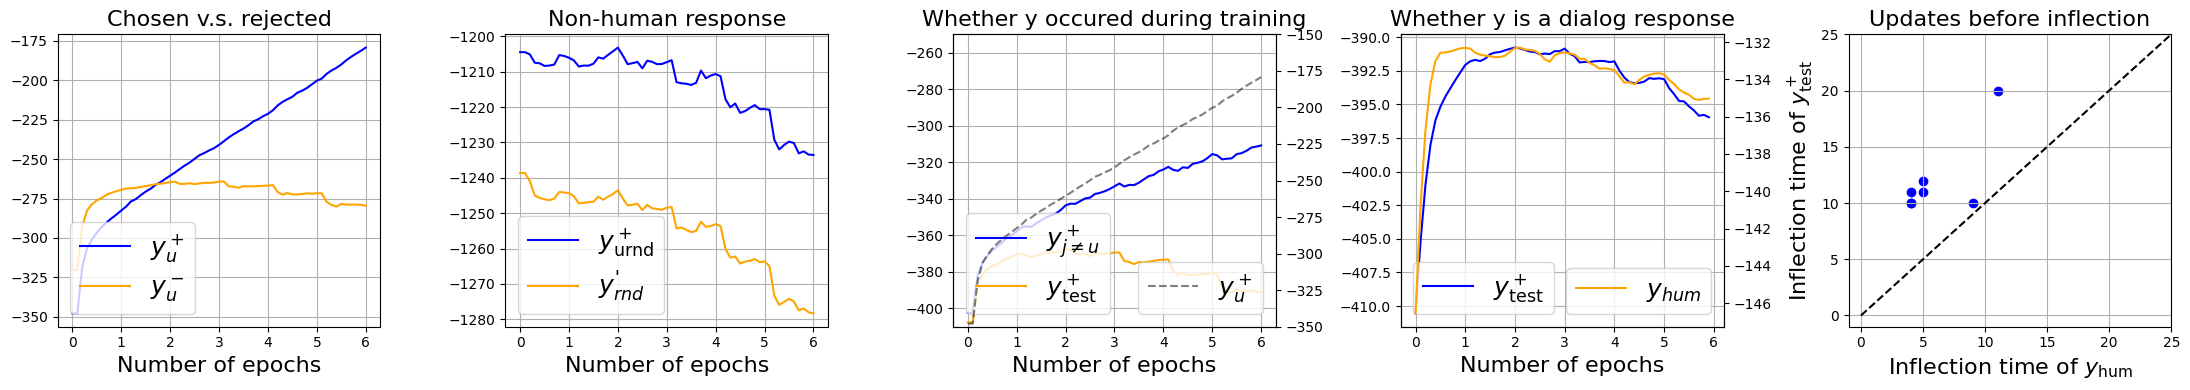

In [46]:
# ----------- UltraFB
PATH = PATH_fb
MODEL_LIST = ['ultrafb_sft_qwen05_ep10', 'ultrafb_sft_pythia410m', 'ultrafb_sft_pythia1b','ultrafb_sft_pythia14','ultrafb_sft_pythia28']
FIG1_KEYS = ['chosen', 'rejected', 'irr_train', 'irr_test', 'irr_hum','random_permute', 'random_nonhum']
X_INTERVAL = 500

model = MODEL_LIST[-1]
model_name = model.split(' ')[0]
file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
results = read_json_old_exps(file_path)

fig, ax = plt.subplots(1,5,figsize=(22,4))
x_axis = np.arange(0,len(results['chosen']))*X_INTERVAL/5000
OBS_NUM = 400

ax[0].plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', color='blue')
ax[0].plot(x_axis[:OBS_NUM], results['rejected'][:OBS_NUM], label=r'$y_u^-$',color='orange')
ax[0].grid(True)
#ax[0].set_xscale('log')
ax[0].legend(fontsize=18, loc='lower left')
ax[0].set_xlabel('Number of epochs',fontsize=16)
ax[0].set_title('Chosen v.s. rejected',fontsize=16)

ax[1].plot(x_axis[:OBS_NUM], results['random_permute'][:OBS_NUM], label=r'$y_\text{urnd}^+$', color='blue')
ax[1].plot(x_axis[:OBS_NUM], results['random_nonhum'][:OBS_NUM], label=r"$y_{rnd}^'$",color='orange')
ax[1].grid(True)
#ax[1].set_xscale('log')
ax[1].legend(fontsize=18,loc='lower left')
ax[1].set_xlabel('Number of epochs',fontsize=16)
ax[1].set_title('Non-human response',fontsize=16)

ax22 = ax[2].twinx()
ax[2].plot(x_axis[:OBS_NUM], results['irr_train'][:OBS_NUM], label=r'$y_{j\neq u}^+$', color='blue')
ax[2].plot(x_axis[:OBS_NUM], results['irr_test'][:OBS_NUM], label=r"$y_\text{test}^+$",color='orange')
ax22.plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', linestyle='dashed', color='black',alpha=0.5)
#ax22.plot(x_axis[:OBS_NUM], results['rejected'][:OBS_NUM], label=r'$y_u^-$', linestyle='dotted', color='black')
ax[2].grid(True)
#ax[2].set_xscale('log')
ax[2].legend(fontsize=18,loc='lower left')
ax22.legend(fontsize=18,loc='lower right')
ax[2].set_ylim(-410, -250)
ax22.set_ylim(-350, -150)
ax[2].set_xlabel('Number of epochs',fontsize=16)
ax[2].set_title('Whether y occured during training',fontsize=16)

model = MODEL_LIST[0]
file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
results = read_json_old_exps(file_path)
x_axis = np.arange(0,len(results['chosen']))*X_INTERVAL/5000

OBS_NUM = 400
ax33 = ax[3].twinx()
ax[3].plot(x_axis[:OBS_NUM], smooth_path(results['irr_test'][:OBS_NUM],alpha=0.5), label=r"$y_\text{test}^+$", color='blue')
ax33.plot(x_axis[:OBS_NUM], smooth_path(results['irr_hum'][:OBS_NUM],alpha=0.5), label=r"$y_{hum}$",color='orange')
ax[3].grid(True)
#ax[3].set_xscale('log')
ax[3].legend(fontsize=18,loc='lower left')
ax33.legend(fontsize=18,loc='lower right')
ax[3].set_xlabel('Number of epochs',fontsize=16)
ax[3].set_title('Whether y is a dialog response',fontsize=16)


irr_hum_list, irr_test_list = [], []
ALPHA = 0
MODEL_LIST = ['ultrafb_sft_qwen05', 'ultrafb_sft_pythia410m', 'ultrafb_sft_pythia1b','ultrafb_sft_pythia14','ultrafb_sft_pythia28',
              'ultrafb_extend_sftep2_qwen18', 'ultrafb_baseline_sftep2_qwen18']
for i in range(len(MODEL_LIST)):
    model = MODEL_LIST[i]
    file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
    results = read_json_old_exps(file_path)
    irr_hum_peak = scipy.signal.find_peaks(smooth_path(results['irr_hum'],alpha=ALPHA))[0][0]
    irr_test_peak = scipy.signal.find_peaks(smooth_path(results['irr_test'],alpha=ALPHA))[0][0]
    irr_hum_list.append(irr_hum_peak)
    irr_test_list.append(irr_test_peak)


ax[4].scatter(irr_hum_list, irr_test_list, color='blue')
ax[4].set_xlim(-1,25)
ax[4].set_ylim(-1,25)
ax[4].set_xlabel(r'Inflection time of $y_\text{hum}$',fontsize=16)
ax[4].set_ylabel(r'Inflection time of $y^+_\text{test}$',fontsize=16)
ax[4].set_title('Updates before inflection',fontsize=16)
ax[4].plot([0,35], [0, 35], color='black', linestyle='dashed')
ax[4].grid(True)


plt.tight_layout()
#save_name = os.path.join('figures',f'fig2_sft_compare_fb.pdf')
#plt.savefig(save_name)

### DPO part

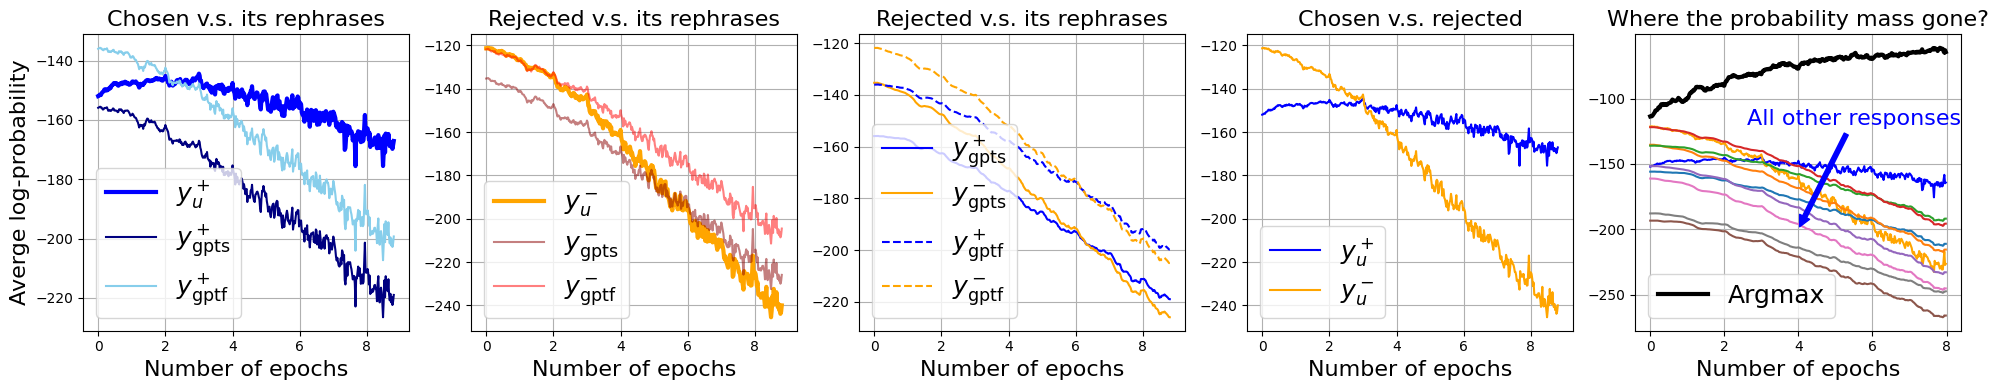

In [67]:
PATH = PATH_hh
model = "dpo_pythia410m"# 'dpo_pythia28'#
file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
results = read_json_old_exps(file_path)
results_argmax = read_json_old_exps(os.path.join(PATH, 'dpo_pythia410m_sft0_observeargmax2/prob_train_metrics.json'))


x_axis = np.arange(0,len(results['chosen']))*100/5000
OBS_NUM = -1
fig, ax = plt.subplots(1,5,figsize=(20,4))

A = 3

ax[A].plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', color='blue')
ax[A].plot(x_axis[:OBS_NUM], results['rejected'][:OBS_NUM], label=r'$y_u^-$',color='orange')
ax[A].grid(True)
ax[A].legend(fontsize=18, loc='lower left')
ax[A].set_title('Chosen v.s. rejected',fontsize=16)
ax[A].set_xlabel('Number of epochs',fontsize=16)

B = 0
ax[B].plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', color='blue', linewidth=3)
ax[B].plot(x_axis[:OBS_NUM], results['chosen_gptsemantic'][:OBS_NUM], label=r'$y_\text{gpts}^+$',color='navy')
ax[B].plot(x_axis[:OBS_NUM], results['chosen_gptformat'][:OBS_NUM], label=r'$y_\text{gptf}^+$',color='skyblue')
ax[B].grid(True)
ax[B].legend(fontsize=18, loc='lower left')
ax[B].set_title('Chosen v.s. its rephrases',fontsize=16)
ax[B].set_xlabel('Number of epochs',fontsize=16)
ax[B].set_ylabel('Averge log-probability',fontsize=16)

C = 1
ax[C].plot(x_axis[:OBS_NUM], results['rejected'][:OBS_NUM], label=r'$y_u^-$', color='orange', linewidth=3)
ax[C].plot(x_axis[:OBS_NUM], results['reject_gptsemantic'][:OBS_NUM], label=r'$y_\text{gpts}^-$',color='darkred',alpha=0.5)
ax[C].plot(x_axis[:OBS_NUM], results['reject_gptformat'][:OBS_NUM], label=r'$y_\text{gptf}^-$',color='red',alpha=0.5)
ax[C].grid(True)
ax[C].legend(fontsize=18, loc='lower left')
ax[C].set_title('Rejected v.s. its rephrases',fontsize=16)
ax[C].set_xlabel('Number of epochs',fontsize=16)

D = 2
ax[D].plot(x_axis[:OBS_NUM], smooth_path(results['chosen_gptsemantic'][:OBS_NUM], 0.9), label=r'$y_\text{gpts}^+$',color='blue')
ax[D].plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptsemantic'][:OBS_NUM], 0.9), label=r'$y_\text{gpts}^-$',color='orange')
ax[D].plot(x_axis[:OBS_NUM], smooth_path(results['chosen_gptformat'][:OBS_NUM], 0.9), label=r'$y_\text{gptf}^+$',color='blue',linestyle='dashed')
ax[D].plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptformat'][:OBS_NUM], 0.9), label=r'$y_\text{gptf}^-$',color='orange',linestyle='dashed')
ax[D].grid(True)
ax[D].legend(fontsize=18, loc='lower left')#,ncol=2)
ax[D].set_title('Rejected v.s. its rephrases',fontsize=16)
ax[D].set_xlabel('Number of epochs',fontsize=16)

OBS_NUM = 400 
E = 4
ax[E].plot(x_axis[:OBS_NUM], results_argmax['argmax'][:OBS_NUM], label='Argmax', color='black', linewidth=3)
ax[E].plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], color='blue')
ax[E].plot(x_axis[:OBS_NUM], results['rejected'][:OBS_NUM],color='orange')
ax[E].plot(x_axis[:OBS_NUM], smooth_path(results['chosen_gptsemantic'][:OBS_NUM], 0.9))
ax[E].plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptsemantic'][:OBS_NUM], 0.9))
ax[E].plot(x_axis[:OBS_NUM], smooth_path(results['chosen_gptformat'][:OBS_NUM], 0.9))
ax[E].plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptformat'][:OBS_NUM], 0.9))
ax[E].plot(x_axis[:OBS_NUM], smooth_path(results['chosen_initial'][:OBS_NUM], 0.9))
ax[E].plot(x_axis[:OBS_NUM], smooth_path(results['irr_train'][:OBS_NUM], 0.9))
ax[E].plot(x_axis[:OBS_NUM], smooth_path(results['irr_test'][:OBS_NUM], 0.9))
ax[E].plot(x_axis[:OBS_NUM], smooth_path(results['irr_hum'][:OBS_NUM], 0.9))
#ax[E].plot(x_axis[:OBS_NUM], smooth_path(results['random_permute'][:OBS_NUM], 0.9), color='cyan', label='Non-hum')
#ax[E].plot(x_axis[:OBS_NUM], smooth_path(results['random_nonhum'][:OBS_NUM], 0.9), color='lightblue')

ax[E].annotate('All other responses', xy=(4,-200), xytext=(5.5, -120), arrowprops=dict(arrowstyle="simple",color='blue',),
                      horizontalalignment='center',color='blue',fontsize=16)

ax[4].grid(True)
ax[4].legend(fontsize=18, loc='lower left')#,ncol=2)
ax[4].set_title('Where the probability mass gone?',fontsize=16)
ax[4].set_xlabel('Number of epochs',fontsize=16)

plt.tight_layout()
save_name = os.path.join('figures','dpo_all.pdf')
plt.savefig(save_name)

### Appendix, 5 models, trend similar

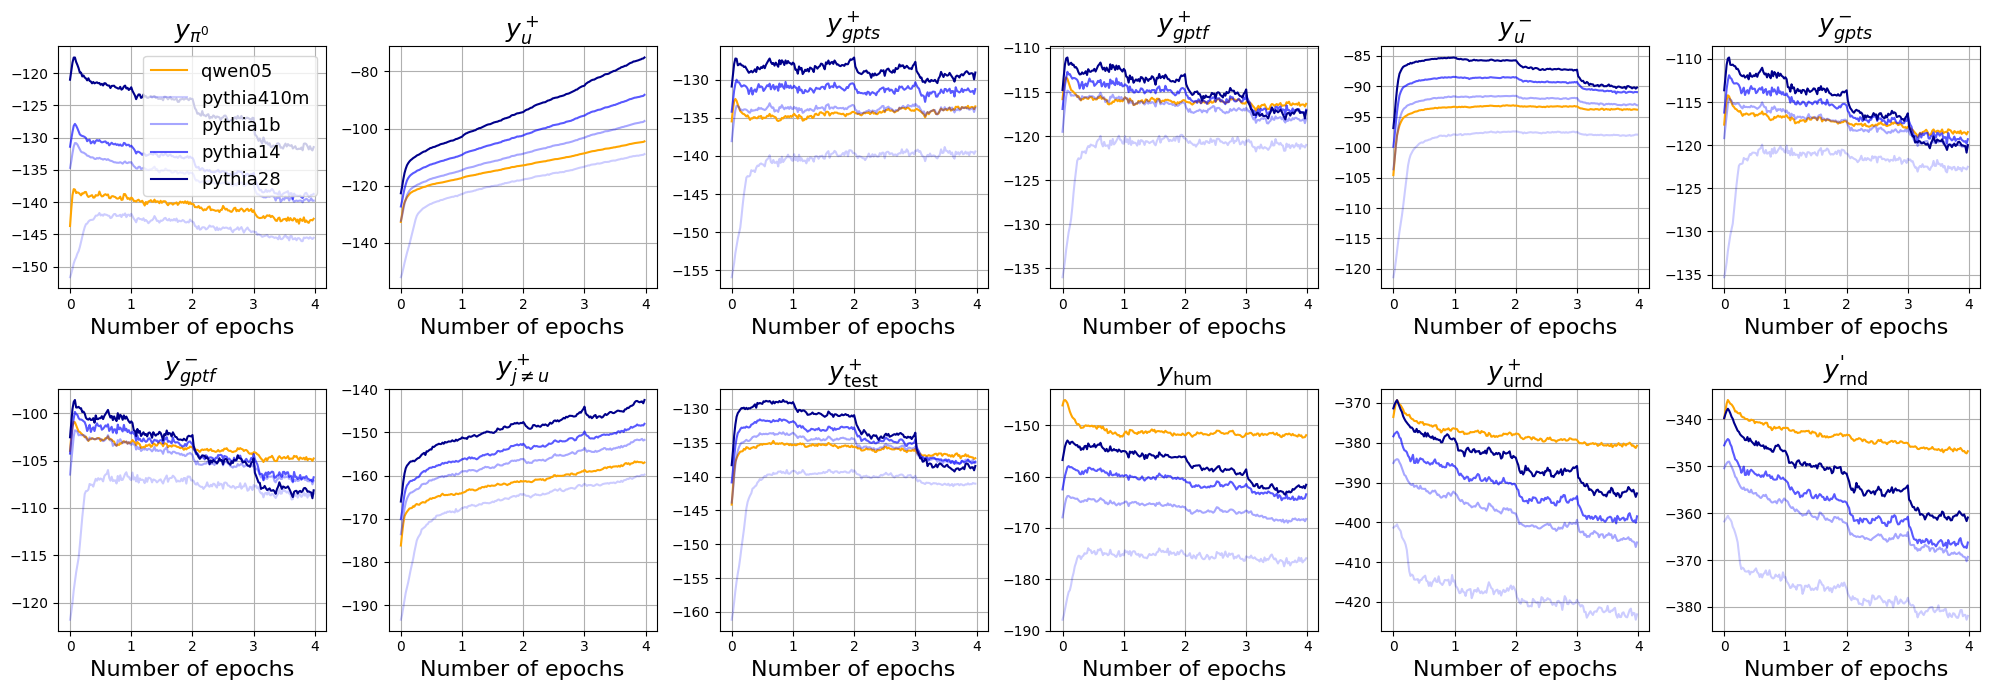

In [5]:
PATH = PATH_hh
#FIG1_KEYS = ['chosen', 'rejected', 'irr_train', 'irr_test', 'irr_hum','random_permute', 'random_nonhum']
FIG1_KEYS = ['chosen_initial', 'chosen', 'chosen_gptsemantic', 'chosen_gptformat',
                 'rejected', 'reject_gptsemantic', 'reject_gptformat',
                 'irr_train', 'irr_test', 'irr_hum',
                 'random_permute', 'random_nonhum'
                ]
MODEL_LIST = ['qwen05_20240419', 'pythia410m_20240416', 'pythia1b_ep6', 'pythia14_ep6','pythia28_ep6'] #'pythia1b_20240416' pythia14_20240416
COLORS = ['orange', 'blue', 'blue', 'blue', 'darkblue']
ALPHAS = [1, 0.2, 0.35, 0.65, 1]
TITLES = [r'$y_{\pi^0}$', r'$y_u^+$', r'$y_{gpts}^+$', r'$y_{gptf}^+$', 
          r'$y_u^-$', r'$y_{gpts}^-$', r'$y_{gptf}^-$', 
          r'$y_{j\neq u}^+$', r'$y_\text{test}^+$', r'$y_\text{hum}$', 
          r'$y_\text{urnd}^+$', r"$y_\text{rnd}^'$"]

fig, ax = plt.subplots(2,6,figsize=(20, 7))
OBS_NUM = 200
for j in range(len(MODEL_LIST)):
    file_path = os.path.join(PATH, MODEL_LIST[j], 'prob_train_metrics.json')
    results = read_json_old_exps(file_path)
    x_axis = np.arange(0,len(results['chosen']))*100/ 5000
    for k in range(2):
        for i in range(6):
            idx = k*6 + i
            ax[k][i].set_xlabel('Number of epochs',fontsize=16)
            ax[k][i].set_title(TITLES[idx],fontsize=18)
            if i==0 and k==0:
                label = MODEL_LIST[j].split('_')[0]
                ax[k][i].plot(x_axis[:OBS_NUM] ,results[FIG1_KEYS[idx]][:OBS_NUM],linewidth=1.5, color= COLORS[j], alpha=ALPHAS[j] ,label=label)
                ax[k][i].legend(fontsize=13)
            else:
                ax[k][i].plot(x_axis[:OBS_NUM] ,results[FIG1_KEYS[idx]][:OBS_NUM],linewidth=1.5,color= COLORS[j], alpha=ALPHAS[j])
            ax[k][i].grid(True)
        
plt.tight_layout()
save_name = os.path.join('figures','app_allmodels_all_curves.pdf')
plt.savefig(save_name)

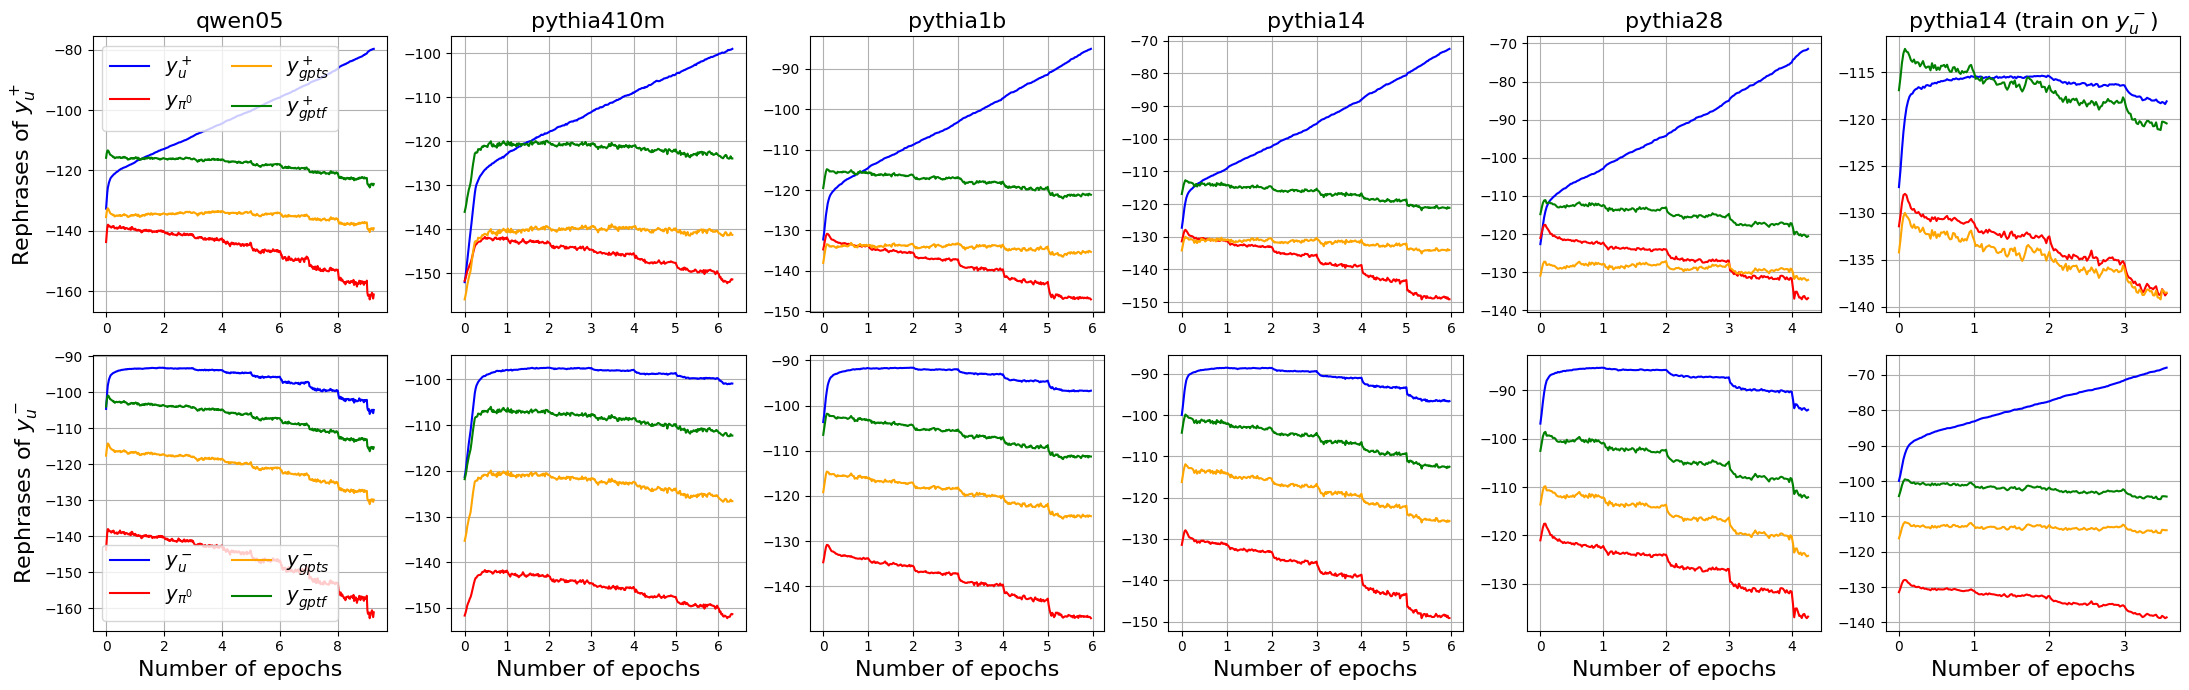

In [79]:
fig, ax = plt.subplots(2,6,figsize=(22, 7))
PATH = PATH_hh
COLORS = ['blue', 'red', 'orange', 'green']
CHOSEN_KEYS = ['chosen', 'chosen_initial', 'chosen_gptsemantic', 'chosen_gptformat']
CHOSEN_LABELS = [r'$y_u^+$', r'$y_{\pi^0}$', r'$y_{gpts}^+$', r'$y_{gptf}^+$'] #['initial', 'chosen', 'gpt_semantic', 'gpt_format']#
REJECT_KEYS = ['rejected', 'chosen_initial', 'reject_gptsemantic', 'reject_gptformat']
REJECT_LABELS = [r'$y_u^-$', r'$y_{\pi^0}$', r'$y_{gpts}^-$', r'$y_{gptf}^-$']
MODEL_LIST = ['qwen05_20240419', 'pythia410m_20240416', 'pythia1b_ep6', 'pythia14_ep6','pythia28_ep6']
#['qwen05_20240419', 'pythia410m_20240416', 'pythia1b_20240416','pythia14_20240416','pythia28_20240416']

OBS_NUM = -1
# --------- Draw Chosens
for i in range(5):
    file_path = os.path.join(PATH, MODEL_LIST[i], 'prob_train_metrics.json')
    results = read_json_old_exps(file_path)
    x_axis = np.arange(0,len(results['chosen']))*100/5000
    ax[0][i].set_title(MODEL_LIST[i].split('_')[0],fontsize=16)
    for j in range(len(CHOSEN_KEYS)):
        ax[0][i].plot(x_axis[:OBS_NUM] ,results[CHOSEN_KEYS[j]][:OBS_NUM],linewidth=1.5, label=CHOSEN_LABELS[j], color=COLORS[j])
        ax[0][i].grid(True)
ax[0][0].legend(fontsize=14, ncol=2)
ax[0][0].set_ylabel(r'Rephrases of $y_u^+$',fontsize=16)

# --------- Draw Rejected
for i in range(5):
    file_path = os.path.join(PATH, MODEL_LIST[i], 'prob_train_metrics.json')
    results = read_json_old_exps(file_path)
    x_axis = np.arange(0,len(results['rejected']))*100/5000
    for j in range(len(REJECT_KEYS)):
        ax[1][i].plot(x_axis[:OBS_NUM] ,results[REJECT_KEYS[j]][:OBS_NUM],linewidth=1.5, label=REJECT_LABELS[j], color=COLORS[j])
        ax[1][i].grid(True)
        ax[1][i].set_xlabel('Number of epochs',fontsize=16)
ax[1][0].legend(fontsize=14, ncol=2)
ax[1][0].set_ylabel(r'Rephrases of $y_u^-$',fontsize=16)


# ---------- The last column
file_path = os.path.join(PATH, 'pythia14_supreject_20240419', 'prob_train_metrics.json')
results = read_json_old_exps(file_path)
x_axis = np.arange(0,len(results['rejected']))*100/5000

ax[0][5].set_title(r'pythia14 (train on $y_u^-$)',fontsize=16)
for j in range(len(CHOSEN_KEYS)):
    ax[0][5].plot(x_axis[:OBS_NUM] ,results[CHOSEN_KEYS[j]][:OBS_NUM],linewidth=1.5, label=CHOSEN_LABELS[j], color=COLORS[j])
    ax[0][5].grid(True)

for j in range(len(REJECT_KEYS)):
    ax[1][5].plot(x_axis[:OBS_NUM] ,results[REJECT_KEYS[j]][:OBS_NUM],linewidth=1.5, label=REJECT_LABELS[j], color=COLORS[j])
    ax[1][5].grid(True)
ax[1][5].set_xlabel('Number of epochs',fontsize=16)

plt.tight_layout()
save_name = os.path.join('figures','app_rephrases.pdf')
plt.savefig(save_name)

#### UltraFeedback

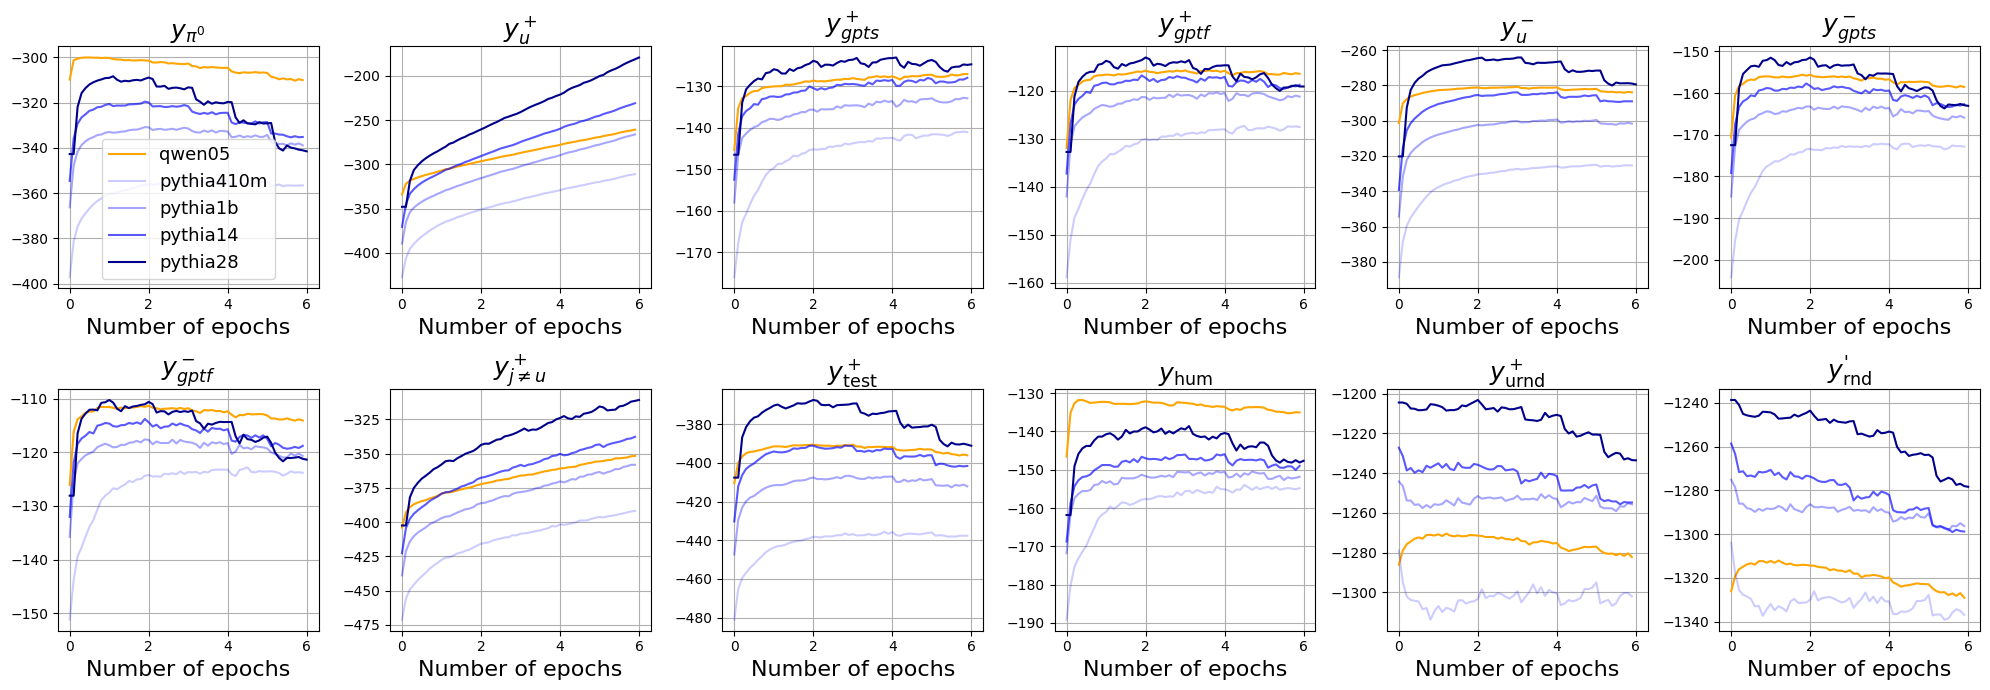

In [61]:
PATH = PATH_fb
X_INTERVAL = 500
MODEL_LIST = ['ultrafb_sft_qwen05', 'ultrafb_sft_pythia410m', 'ultrafb_sft_pythia1b','ultrafb_sft_pythia14','ultrafb_sft_pythia28']
#FIG1_KEYS = ['chosen', 'rejected', 'irr_train', 'irr_test', 'irr_hum','random_permute', 'random_nonhum']
FIG1_KEYS = ['chosen_initial', 'chosen', 'chosen_gptsemantic', 'chosen_gptformat',
                 'rejected', 'reject_gptsemantic', 'reject_gptformat',
                 'irr_train', 'irr_test', 'irr_hum',
                 'random_permute', 'random_nonhum'
                ]
COLORS = ['orange', 'blue', 'blue', 'blue', 'darkblue']
ALPHAS = [1, 0.2, 0.35, 0.65, 1]
TITLES = [r'$y_{\pi^0}$', r'$y_u^+$', r'$y_{gpts}^+$', r'$y_{gptf}^+$', 
          r'$y_u^-$', r'$y_{gpts}^-$', r'$y_{gptf}^-$', 
          r'$y_{j\neq u}^+$', r'$y_\text{test}^+$', r'$y_\text{hum}$', 
          r'$y_\text{urnd}^+$', r"$y_\text{rnd}^'$"]

fig, ax = plt.subplots(2,6,figsize=(20, 7))
OBS_NUM = 300
for j in range(len(MODEL_LIST)):
    file_path = os.path.join(PATH, MODEL_LIST[j], 'prob_train_metrics.json')
    results = read_json_old_exps(file_path)
    x_axis = np.arange(0,len(results['chosen']))*X_INTERVAL/ 5000
    for k in range(2):
        for i in range(6):
            idx = k*6 + i
            ax[k][i].set_xlabel('Number of epochs',fontsize=16)
            ax[k][i].set_title(TITLES[idx],fontsize=18)
            if i==0 and k==0:
                label = MODEL_LIST[j].split('_')[-1]
                ax[k][i].plot(x_axis[:OBS_NUM] ,results[FIG1_KEYS[idx]][:OBS_NUM],linewidth=1.5, color= COLORS[j], alpha=ALPHAS[j] ,label=label)
                ax[k][i].legend(fontsize=13)
            else:
                ax[k][i].plot(x_axis[:OBS_NUM] ,results[FIG1_KEYS[idx]][:OBS_NUM],linewidth=1.5,color= COLORS[j], alpha=ALPHAS[j])
            ax[k][i].grid(True)
        
plt.tight_layout()
# save_name = os.path.join('figures','app_allmodels_all_curves_fb.pdf')
# plt.savefig(save_name)


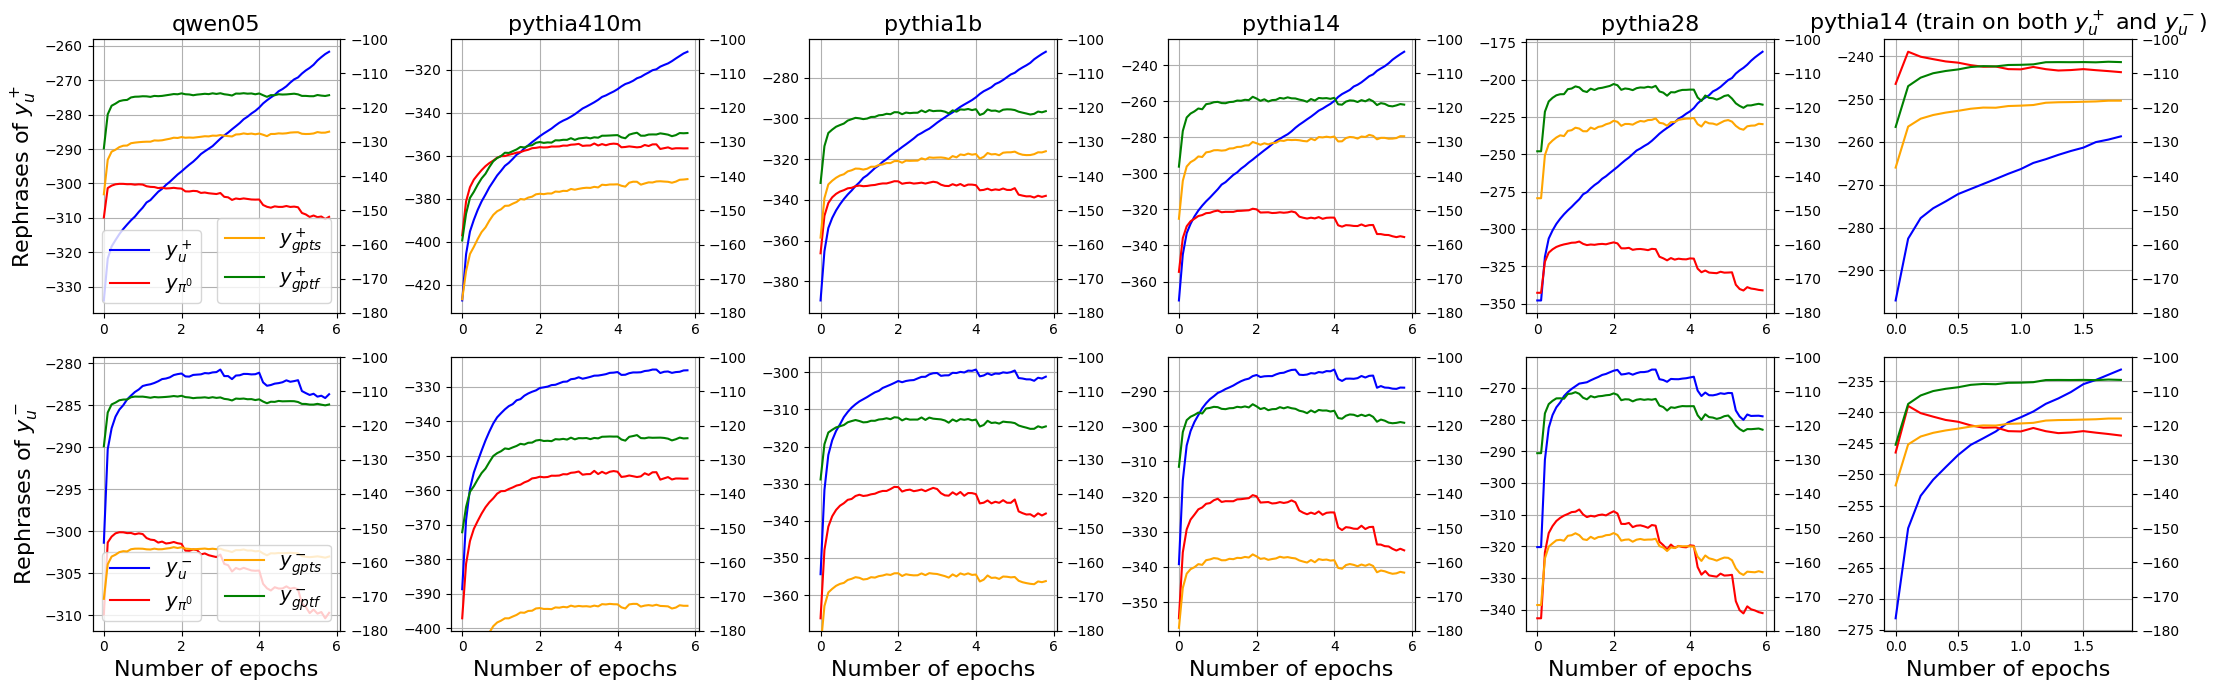

In [76]:
fig, ax = plt.subplots(2,6,figsize=(22, 7))
PATH = PATH_fb
X_INTERVAL = 500
COLORS = ['blue', 'red', 'orange', 'green']
CHOSEN_KEYS = ['chosen', 'chosen_initial', 'chosen_gptsemantic', 'chosen_gptformat']
CHOSEN_LABELS = [r'$y_u^+$', r'$y_{\pi^0}$', r'$y_{gpts}^+$', r'$y_{gptf}^+$'] #['initial', 'chosen', 'gpt_semantic', 'gpt_format']#
REJECT_KEYS = ['rejected', 'chosen_initial', 'reject_gptsemantic', 'reject_gptformat']
REJECT_LABELS = [r'$y_u^-$', r'$y_{\pi^0}$', r'$y_{gpts}^-$', r'$y_{gptf}^-$']
MODEL_LIST = ['ultrafb_sft_qwen05', 'ultrafb_sft_pythia410m', 'ultrafb_sft_pythia1b','ultrafb_sft_pythia14','ultrafb_sft_pythia28']

OBS_NUM = -1
# --------- Draw Chosens
for i in range(5):
    file_path = os.path.join(PATH, MODEL_LIST[i], 'prob_train_metrics.json')
    results = read_json_old_exps(file_path)
    x_axis = np.arange(0,len(results['chosen']))*X_INTERVAL/5000
    ax[0][i].set_title(MODEL_LIST[i].split('_')[-1],fontsize=16)
    axxx = ax[0][i].twinx()
    axxx.set_ylim(-180,-100)
    for j in range(len(CHOSEN_KEYS)):
        if j==0 or j==1:
            ax[0][i].plot(x_axis[:OBS_NUM] ,results[CHOSEN_KEYS[j]][:OBS_NUM],linewidth=1.5, label=CHOSEN_LABELS[j], color=COLORS[j])
            ax[0][i].grid(True)
        else:
            axxx.plot(x_axis[:OBS_NUM] ,results[CHOSEN_KEYS[j]][:OBS_NUM],linewidth=1.5, label=CHOSEN_LABELS[j], color=COLORS[j]) 
    if i==0:
        axxx.legend(fontsize=14, ncol=1,loc='lower right')
ax[0][0].legend(fontsize=14, ncol=1,loc='lower left')
ax[0][0].set_ylabel(r'Rephrases of $y_u^+$',fontsize=16)

# --------- Draw Rejected
for i in range(5):
    file_path = os.path.join(PATH, MODEL_LIST[i], 'prob_train_metrics.json')
    results = read_json_old_exps(file_path)
    x_axis = np.arange(0,len(results['rejected']))*X_INTERVAL/5000
    axxx = ax[1][i].twinx()
    axxx.set_ylim(-180,-100)
    for j in range(len(REJECT_KEYS)):
        if j==0 or j==1:
            ax[1][i].plot(x_axis[:OBS_NUM] ,results[REJECT_KEYS[j]][:OBS_NUM],linewidth=1.5, label=REJECT_LABELS[j], color=COLORS[j])
            ax[1][i].grid(True)
            ax[1][i].set_xlabel('Number of epochs',fontsize=16)
        else:
            axxx.plot(x_axis[:OBS_NUM] ,results[REJECT_KEYS[j]][:OBS_NUM],linewidth=1.5, label=REJECT_LABELS[j], color=COLORS[j])
    if i==0:
        axxx.legend(fontsize=14, ncol=1,loc='lower right')
ax[1][0].legend(fontsize=14, ncol=1,loc='lower left')
ax[1][0].set_ylabel(r'Rephrases of $y_u^-$',fontsize=16)


# ---------- The last column
file_path = os.path.join(PATH, 'ultrafb_extend_sftep2_qwen18', 'prob_train_metrics.json')
results = read_json_old_exps(file_path)
x_axis = np.arange(0,len(results['rejected']))*X_INTERVAL/5000

ax[0][5].set_title(r'pythia14 (train on both $y_u^+$ and $y_u^-$)',fontsize=16)
axxx = ax[0][5].twinx()
axxx.set_ylim(-180,-100)
for j in range(len(CHOSEN_KEYS)):
    if j==0 or j==1:
        ax[0][5].plot(x_axis[:OBS_NUM] ,results[CHOSEN_KEYS[j]][:OBS_NUM],linewidth=1.5, label=CHOSEN_LABELS[j], color=COLORS[j])
        ax[0][5].grid(True)
    else:
        axxx.plot(x_axis[:OBS_NUM] ,results[CHOSEN_KEYS[j]][:OBS_NUM],linewidth=1.5, label=CHOSEN_LABELS[j], color=COLORS[j])

axxx = ax[1][5].twinx()
axxx.set_ylim(-180,-100)
for j in range(len(REJECT_KEYS)):
    if j==0 or j==1:
        ax[1][5].plot(x_axis[:OBS_NUM] ,results[REJECT_KEYS[j]][:OBS_NUM],linewidth=1.5, label=REJECT_LABELS[j], color=COLORS[j])
        ax[1][5].grid(True)
    else:
        axxx.plot(x_axis[:OBS_NUM] ,results[CHOSEN_KEYS[j]][:OBS_NUM],linewidth=1.5, label=CHOSEN_LABELS[j], color=COLORS[j])
ax[1][5].set_xlabel('Number of epochs',fontsize=16)

plt.tight_layout()
save_name = os.path.join('figures','app_rephrases_fb.pdf')
plt.savefig(save_name)

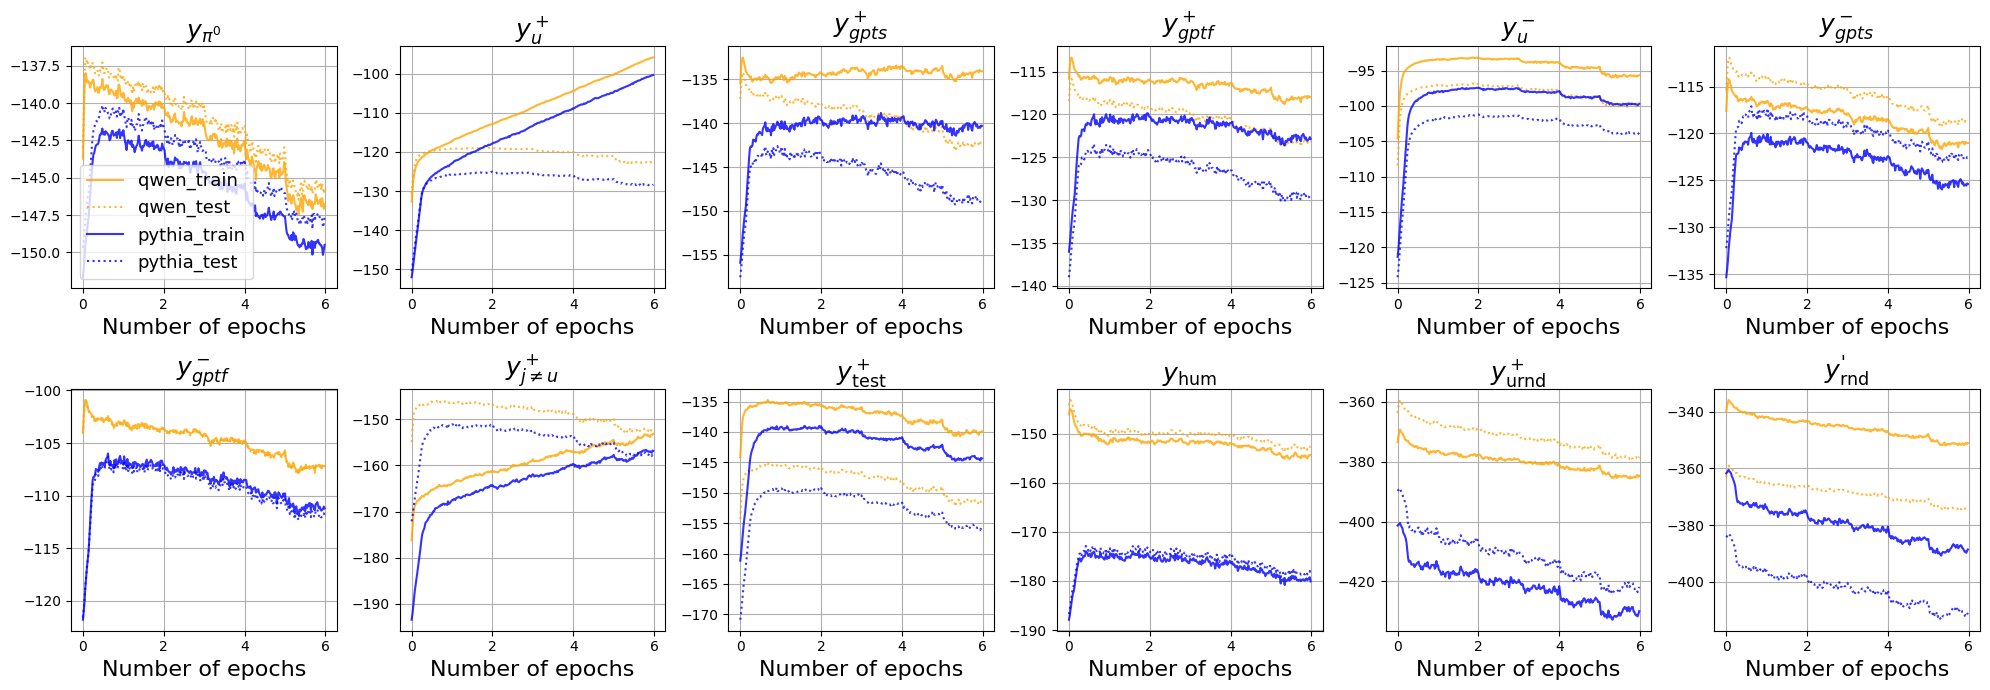

In [188]:
PATH = PATH_hh
X_INTERVAL = 100
#FIG1_KEYS = ['chosen', 'rejected', 'irr_train', 'irr_test', 'irr_hum','random_permute', 'random_nonhum']
FIG1_KEYS = ['chosen_initial', 'chosen', 'chosen_gptsemantic', 'chosen_gptformat',
                 'rejected', 'reject_gptsemantic', 'reject_gptformat',
                 'irr_train', 'irr_test', 'irr_hum',
                 'random_permute', 'random_nonhum'
                ]
MODEL_LIST = ['qwen05_20240419', 'pythia410m_20240416', 'pythia1b_20240416','pythia14_20240416','pythia28_ep6']
COLORS = ['orange', 'blue', 'blue', 'blue', 'blue']
ALPHAS = [1, 0.2, 0.35, 0.65, 1]
TITLES = [r'$y_{\pi^0}$', r'$y_u^+$', r'$y_{gpts}^+$', r'$y_{gptf}^+$', 
          r'$y_u^-$', r'$y_{gpts}^-$', r'$y_{gptf}^-$', 
          r'$y_{j\neq u}^+$', r'$y_\text{test}^+$', r'$y_\text{hum}$', 
          r'$y_\text{urnd}^+$', r"$y_\text{rnd}^'$"]
LABELS = ['qwen', 'pythia']
fig, ax = plt.subplots(2,6,figsize=(20, 7))
OBS_NUM = 300
for j in range(2):
    file_path = os.path.join(PATH, MODEL_LIST[j], 'prob_train_metrics.json')
    results_train = read_json_old_exps(file_path, train_test='train')
    file_path = os.path.join(PATH, MODEL_LIST[j], 'prob_test_metrics.json')
    results_test = read_json_old_exps(file_path, train_test='test')    
    x_axis = np.arange(0,len(results_train['chosen']))*100/ 5000
    for k in range(2):
        for i in range(6):
            idx = k*6 + i
            ax[k][i].set_xlabel('Number of epochs',fontsize=16)
            ax[k][i].set_title(TITLES[idx],fontsize=18)
            if i==0 and k==0:
                label = MODEL_LIST[j].split('_')[0]
                ax[k][i].plot(x_axis[:OBS_NUM] ,results_train[FIG1_KEYS[idx]][:OBS_NUM],linewidth=1.5, color=COLORS[j], alpha=0.8, label=LABELS[j]+'_train')
                ax[k][i].plot(x_axis[:OBS_NUM] ,results_test[FIG1_KEYS[idx]][:OBS_NUM],linewidth=1.5, color=COLORS[j], alpha=0.8, ls='dotted',label=LABELS[j]+'_test')
                ax[k][i].legend(fontsize=13)
            else:
                ax[k][i].plot(x_axis[:OBS_NUM] ,results_train[FIG1_KEYS[idx]][:OBS_NUM],linewidth=1.5, color= COLORS[j], alpha=0.8)
                ax[k][i].plot(x_axis[:OBS_NUM] ,results_test[FIG1_KEYS[idx]][:OBS_NUM],linewidth=1.5 , ls='dotted', color= COLORS[j], alpha=0.8)
            ax[k][i].grid(True)
        
plt.tight_layout()
save_name = os.path.join('figures','app_dptrain_dptest.pdf')
#plt.savefig(save_name)

### Appendix DPO -- all

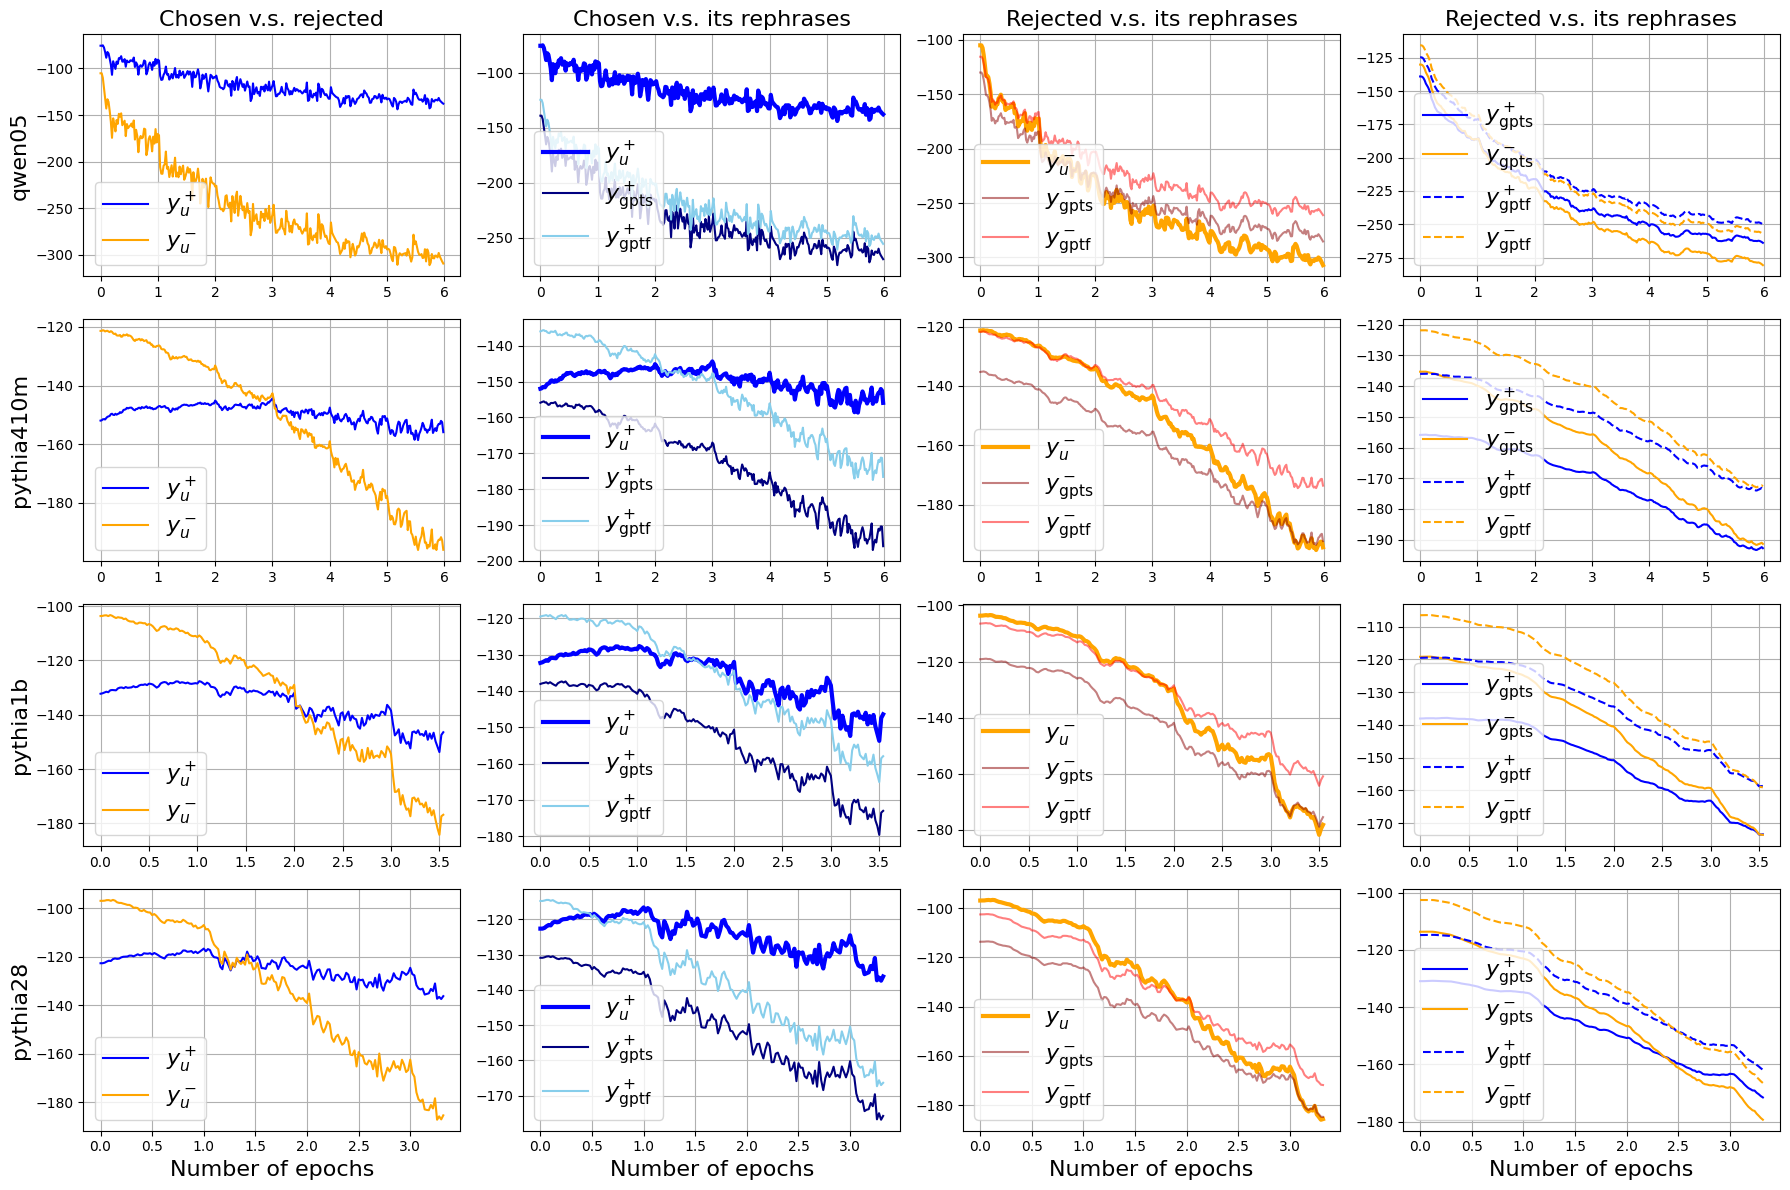

In [133]:

PATH = PATH_hh
X_INTERVAL = 100
model = "dpo_pythia410m"# 'dpo_pythia28'#
fig, ax = plt.subplots(4,4,figsize=(18,12))
MODEL_LIST = ["dpo_qwen05_sft10", "dpo_pythia410m",  "dpo_pythia1b_sft0", "dpo_pythia28"]
TITLE_LIST = ['qwen05', 'pythia410m',  'pythia1b', 'pythia28']
for i in range(4):
    model = MODEL_LIST[i]
    file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
    results = read_json_old_exps(file_path)
    x_axis = np.arange(0,len(results['chosen']))*100/5000
    OBS_NUM = 300
    ax[i][0].plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', color='blue')
    ax[i][0].plot(x_axis[:OBS_NUM], results['rejected'][:OBS_NUM], label=r'$y_u^-$',color='orange')
    ax[i][0].grid(True)
    ax[i][0].legend(fontsize=16, loc='lower left')
    ax[i][0].set_ylabel(TITLE_LIST[i], fontsize=16)
    
    ax[i][1].plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', color='blue', linewidth=3)
    ax[i][1].plot(x_axis[:OBS_NUM], results['chosen_gptsemantic'][:OBS_NUM], label=r'$y_\text{gpts}^+$',color='navy')
    ax[i][1].plot(x_axis[:OBS_NUM], results['chosen_gptformat'][:OBS_NUM], label=r'$y_\text{gptf}^+$',color='skyblue')
    ax[i][1].grid(True)
    ax[i][1].legend(fontsize=16, loc='lower left')

    ax[i][2].plot(x_axis[:OBS_NUM], smooth_path(results['rejected'][:OBS_NUM], 0.5), label=r'$y_u^-$', color='orange', linewidth=3)
    ax[i][2].plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptsemantic'][:OBS_NUM], 0.5), label=r'$y_\text{gpts}^-$',color='darkred',alpha=0.5)
    ax[i][2].plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptformat'][:OBS_NUM], 0.5), label=r'$y_\text{gptf}^-$',color='red',alpha=0.5)
    ax[i][2].grid(True)
    ax[i][2].legend(fontsize=16, loc='lower left')

    ax[i][3].plot(x_axis[:OBS_NUM], smooth_path(results['chosen_gptsemantic'][:OBS_NUM], 0.9), label=r'$y_\text{gpts}^+$',color='blue')
    ax[i][3].plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptsemantic'][:OBS_NUM], 0.9), label=r'$y_\text{gpts}^-$',color='orange')
    ax[i][3].plot(x_axis[:OBS_NUM], smooth_path(results['chosen_gptformat'][:OBS_NUM], 0.9), label=r'$y_\text{gptf}^+$',color='blue',linestyle='dashed')
    ax[i][3].plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptformat'][:OBS_NUM], 0.9), label=r'$y_\text{gptf}^-$',color='orange',linestyle='dashed')

    
    ax[i][3].grid(True)
    ax[i][3].legend(fontsize=16, loc='lower left')#,ncol=2)

    if i == 0:
        ax[i][0].set_title('Chosen v.s. rejected',fontsize=16)
        ax[i][1].set_title('Chosen v.s. its rephrases',fontsize=16)
        ax[i][2].set_title('Rejected v.s. its rephrases',fontsize=16)
        ax[i][3].set_title('Rejected v.s. its rephrases',fontsize=16)
    if i == 3:
        ax[i][0].set_xlabel('Number of epochs',fontsize=16)
        ax[i][1].set_xlabel('Number of epochs',fontsize=16)
        ax[i][2].set_xlabel('Number of epochs',fontsize=16)
        ax[i][3].set_xlabel('Number of epochs',fontsize=16)

plt.tight_layout()
save_name = os.path.join('figures','app_dpo_all.pdf')
plt.savefig(save_name)

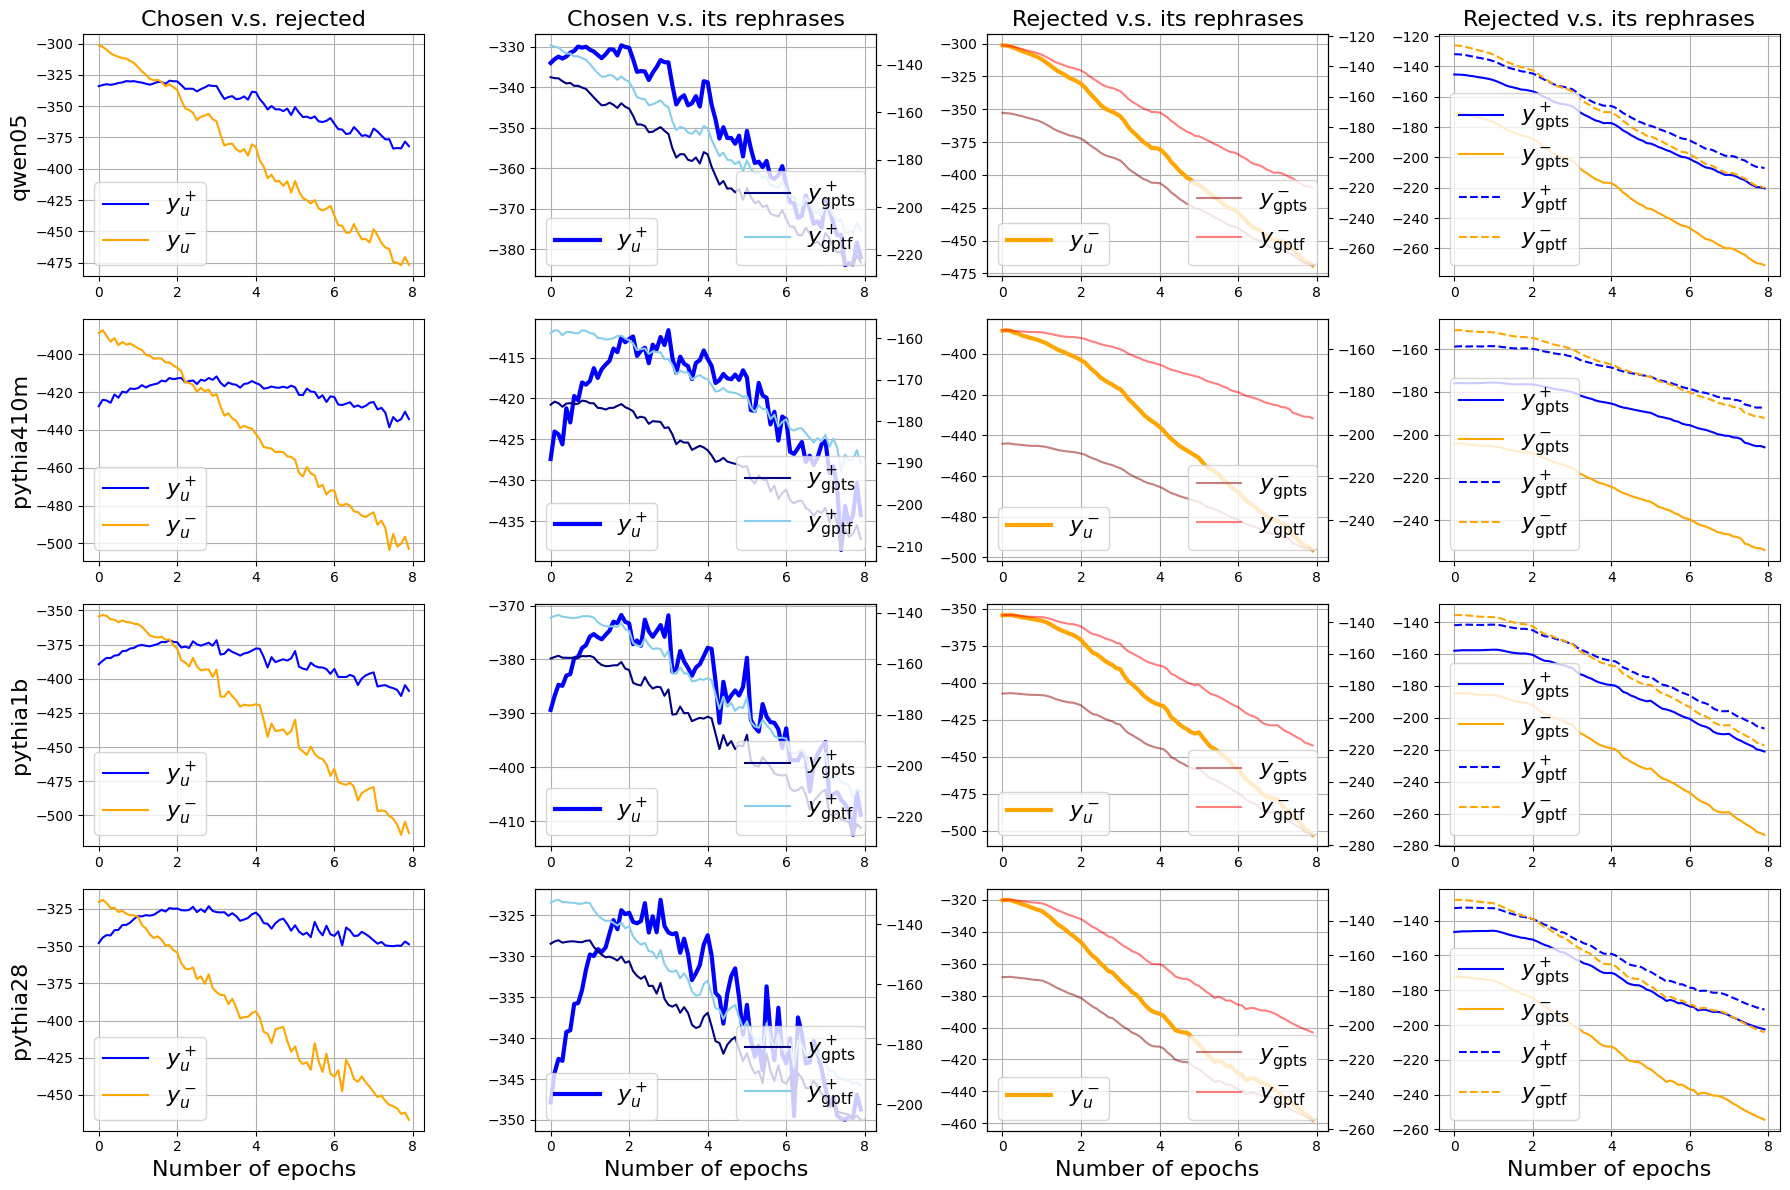

In [132]:
PATH = PATH_fb
X_INTERVAL = 500
SMTH = 0.8
model = "dpo_pythia410m"# 'dpo_pythia28'#
fig, ax = plt.subplots(4,4,figsize=(18,12))
MODEL_LIST = ['ultrafb_dpo_qwen05', 'ultrafb_dpo_pythia410m',  'ultrafb_dpo_pythia1b','ultrafb_dpo_pythia28']
TITLE_LIST = ['qwen05', 'pythia410m',  'pythia1b', 'pythia28']
for i in range(4):
    model = MODEL_LIST[i]
    file_path = os.path.join(PATH, model, 'prob_train_metrics.json')
    results = read_json_old_exps(file_path)
    x_axis = np.arange(0,len(results['chosen']))*X_INTERVAL/5000
    OBS_NUM = 300
    ax[i][0].plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', color='blue')
    ax[i][0].plot(x_axis[:OBS_NUM], results['rejected'][:OBS_NUM], label=r'$y_u^-$',color='orange')
    ax[i][0].grid(True)
    ax[i][0].legend(fontsize=16, loc='lower left')
    ax[i][0].set_ylabel(TITLE_LIST[i], fontsize=16)

    axxx = ax[i][1].twinx()
    ax[i][1].plot(x_axis[:OBS_NUM], results['chosen'][:OBS_NUM], label=r'$y_u^+$', color='blue', linewidth=3)
    axxx.plot(x_axis[:OBS_NUM], results['chosen_gptsemantic'][:OBS_NUM], label=r'$y_\text{gpts}^+$',color='navy')
    axxx.plot(x_axis[:OBS_NUM], results['chosen_gptformat'][:OBS_NUM], label=r'$y_\text{gptf}^+$',color='skyblue')
    ax[i][1].grid(True)
    ax[i][1].legend(fontsize=16, loc='lower left')
    axxx.legend(fontsize=16, loc='lower right')

    axxx = ax[i][2].twinx()
    ax[i][2].plot(x_axis[:OBS_NUM], smooth_path(results['rejected'][:OBS_NUM], SMTH), label=r'$y_u^-$', color='orange', linewidth=3)
    axxx.plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptsemantic'][:OBS_NUM], SMTH), label=r'$y_\text{gpts}^-$',color='darkred',alpha=0.5)
    axxx.plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptformat'][:OBS_NUM], SMTH), label=r'$y_\text{gptf}^-$',color='red',alpha=0.5)
    ax[i][2].grid(True)
    ax[i][2].legend(fontsize=16, loc='lower left')
    axxx.legend(fontsize=16, loc='lower right')

    ax[i][3].plot(x_axis[:OBS_NUM], smooth_path(results['chosen_gptsemantic'][:OBS_NUM], SMTH), label=r'$y_\text{gpts}^+$',color='blue')
    ax[i][3].plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptsemantic'][:OBS_NUM], SMTH), label=r'$y_\text{gpts}^-$',color='orange')
    ax[i][3].plot(x_axis[:OBS_NUM], smooth_path(results['chosen_gptformat'][:OBS_NUM], SMTH), label=r'$y_\text{gptf}^+$',color='blue',linestyle='dashed')
    ax[i][3].plot(x_axis[:OBS_NUM], smooth_path(results['reject_gptformat'][:OBS_NUM], SMTH), label=r'$y_\text{gptf}^-$',color='orange',linestyle='dashed')

    
    ax[i][3].grid(True)
    ax[i][3].legend(fontsize=16, loc='lower left')#,ncol=2)

    if i == 0:
        ax[i][0].set_title('Chosen v.s. rejected',fontsize=16)
        ax[i][1].set_title('Chosen v.s. its rephrases',fontsize=16)
        ax[i][2].set_title('Rejected v.s. its rephrases',fontsize=16)
        ax[i][3].set_title('Rejected v.s. its rephrases',fontsize=16)
    if i == 3:
        ax[i][0].set_xlabel('Number of epochs',fontsize=16)
        ax[i][1].set_xlabel('Number of epochs',fontsize=16)
        ax[i][2].set_xlabel('Number of epochs',fontsize=16)
        ax[i][3].set_xlabel('Number of epochs',fontsize=16)

plt.tight_layout()
save_name = os.path.join('figures','app_dpo_all_fb.pdf')
plt.savefig(save_name)

### Appendix DPO -- SFT first

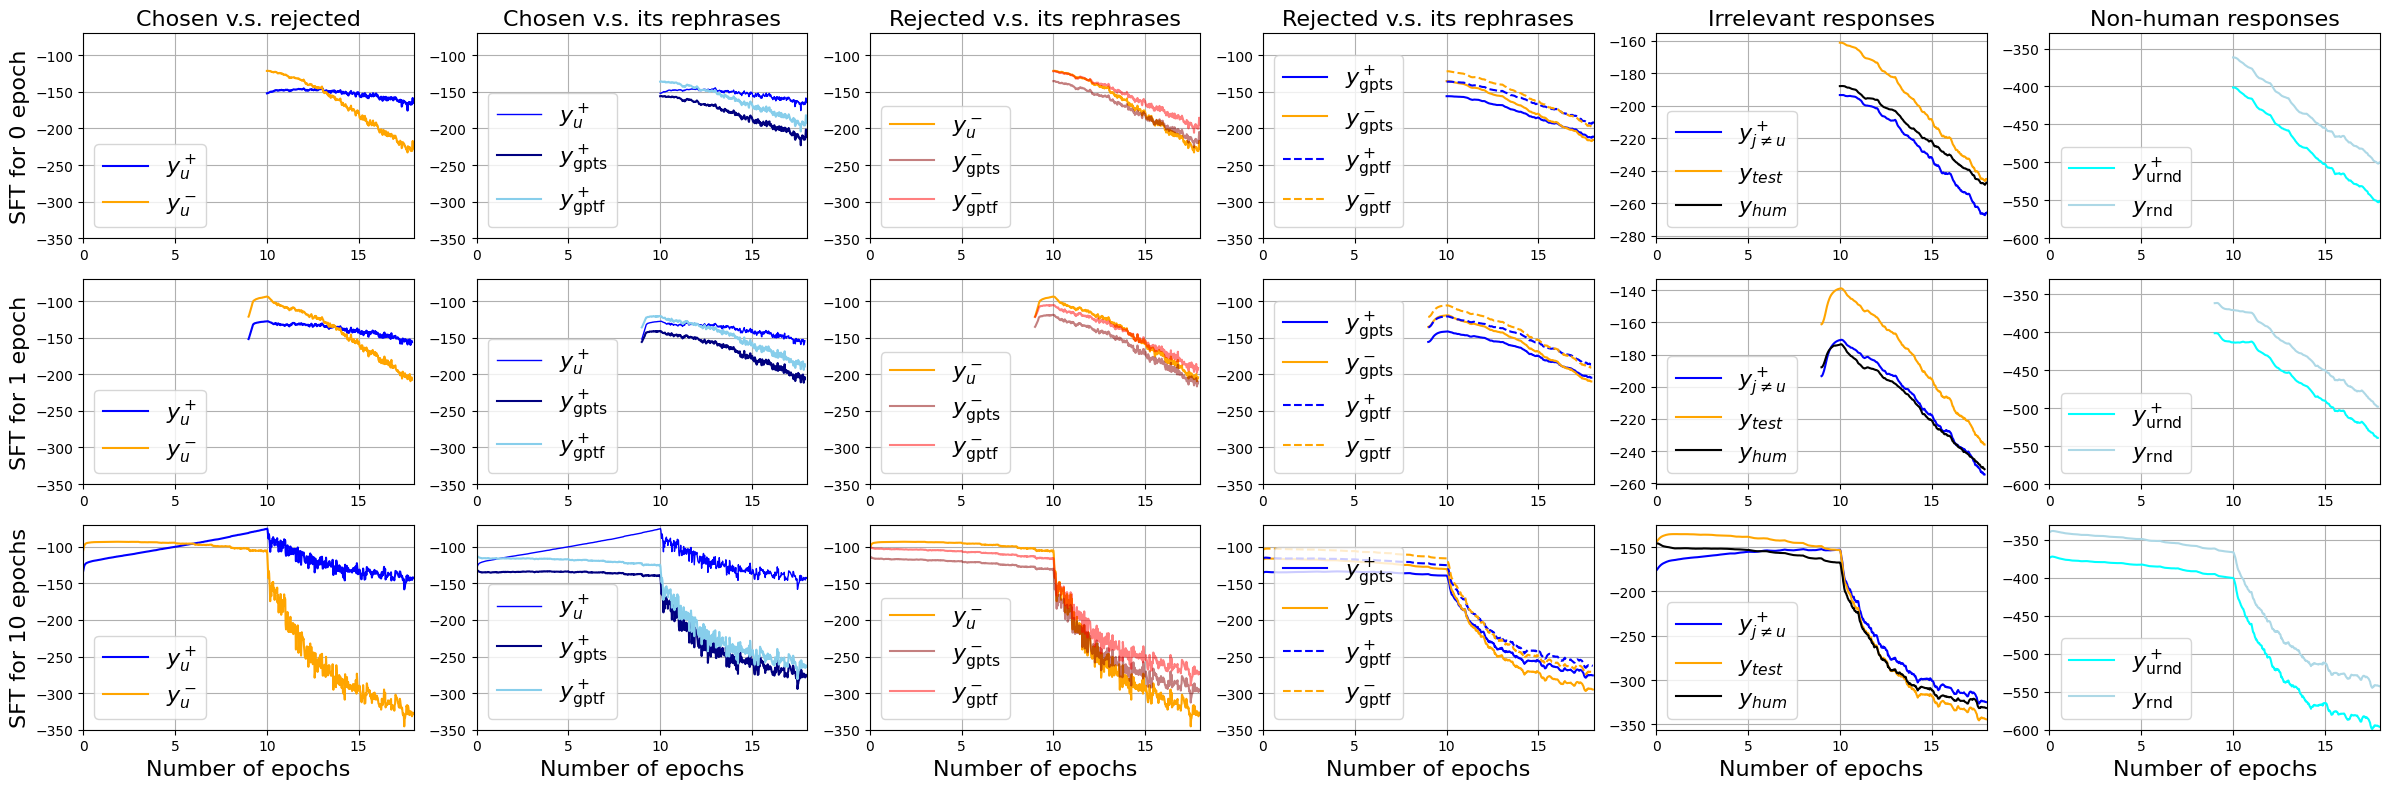

In [51]:
PATH = PATH_hh
MODEL_SEQ = [("dpo_pythia410m", "dpo_pythia410m"),
             ("pythia410m_save_suprej", "dpo_pythia410m_sft_longer"),
             ("qwen05_ep10", "dpo_qwen05_sft10_observeargmax")]
OBS_NUM = -1
fig, ax = plt.subplots(3,6,figsize=(24,8))
X_INTERVAL = 100

for j in range(3):
    file_path = os.path.join(PATH, MODEL_SEQ[j][0], 'prob_train_metrics.json')
    sft_results = read_json_old_exps(file_path)
    file_path = os.path.join(PATH, MODEL_SEQ[j][1], 'prob_train_metrics.json')
    dpo_results = read_json_old_exps(file_path)
    if j == 2:
        x_axis = np.arange(0,len(sft_results['chosen']+dpo_results['chosen']))*X_INTERVAL/5000
    elif j==1:
        x_axis = np.arange(450,450+len(sft_results['chosen']+dpo_results['chosen']))*X_INTERVAL/5000
    else:
        x_axis = np.arange(500,500+len(dpo_results['chosen']))*100/5000
        sft_results = {'chosen':[], 'chosen_initial':[], 'chosen_selfr':[], 'chosen_gptsemantic':[], 'chosen_gptformat':[],
                        'rejected':[], 'reject_gptsemantic':[], 'reject_gptformat':[],
                        'irr_train':[], 'irr_test':[], 'irr_hum':[],
                        'random_permute':[], 'random_nonhum':[]}
    
    ax[j][0].plot(x_axis, sft_results['chosen'] + dpo_results['chosen'], label=r'$y_u^+$', color='blue')
    ax[j][0].plot(x_axis, sft_results['rejected'] + dpo_results['rejected'], label=r'$y_u^-$',color='orange')
    ax[j][0].grid(True)
    ax[j][0].legend(fontsize=16, loc='lower left')#,ncol=2)
    ax[j][0].set_xlim(0, 18)
    ax[j][0].set_ylim(-350, -70)
    
    ax[j][1].plot(x_axis[:OBS_NUM], (sft_results['chosen'] + dpo_results['chosen'])[:OBS_NUM], label=r'$y_u^+$', color='blue', linewidth=1)
    ax[j][1].plot(x_axis[:OBS_NUM], (sft_results['chosen_gptsemantic'] + dpo_results['chosen_gptsemantic'])[:OBS_NUM], label=r'$y_\text{gpts}^+$',color='navy')
    ax[j][1].plot(x_axis[:OBS_NUM], (sft_results['chosen_gptformat'] + dpo_results['chosen_gptformat'])[:OBS_NUM], label=r'$y_\text{gptf}^+$',color='skyblue')
    ax[j][1].grid(True)
    ax[j][1].legend(fontsize=16, loc='lower left')#,ncol=2)
    ax[j][1].set_xlim(0, 18)
    ax[j][1].set_ylim(-350, -70)
    
    ax[j][2].plot(x_axis[:OBS_NUM], (sft_results['rejected'] + dpo_results['rejected'])[:OBS_NUM], label=r'$y_u^-$', color='orange')
    ax[j][2].plot(x_axis[:OBS_NUM], (sft_results['reject_gptsemantic'] + dpo_results['reject_gptsemantic'])[:OBS_NUM], label=r'$y_\text{gpts}^-$',color='darkred',alpha=0.5)
    ax[j][2].plot(x_axis[:OBS_NUM], (sft_results['reject_gptformat'] + dpo_results['reject_gptformat'])[:OBS_NUM], label=r'$y_\text{gptf}^-$',color='red',alpha=0.5)
    ax[j][2].grid(True)
    ax[j][2].legend(fontsize=16, loc='lower left')
    ax[j][2].set_xlim(0, 18)
    ax[j][2].set_ylim(-350, -70)
    
    ax[j][3].plot(x_axis[:OBS_NUM], smooth_path((sft_results['chosen_gptsemantic']+dpo_results['chosen_gptsemantic'])[:OBS_NUM], 0.9), label=r'$y_\text{gpts}^+$',color='blue')
    ax[j][3].plot(x_axis[:OBS_NUM], smooth_path((sft_results['reject_gptsemantic']+dpo_results['reject_gptsemantic'])[:OBS_NUM], 0.9), label=r'$y_\text{gpts}^-$',color='orange')
    ax[j][3].plot(x_axis[:OBS_NUM], smooth_path((sft_results['chosen_gptformat']+dpo_results['chosen_gptformat'])[:OBS_NUM], 0.9), label=r'$y_\text{gptf}^+$',color='blue',linestyle='dashed')
    ax[j][3].plot(x_axis[:OBS_NUM], smooth_path((sft_results['reject_gptformat']+dpo_results['reject_gptformat'])[:OBS_NUM], 0.9), label=r'$y_\text{gptf}^-$',color='orange',linestyle='dashed')
    ax[j][3].grid(True)
    ax[j][3].legend(fontsize=16, loc='lower left')#,ncol=2)
    ax[j][3].set_xlim(0, 18)
    ax[j][3].set_ylim(-350, -70)
    
    # ax[j][4].plot(x_axis[:OBS_NUM], smooth_path((sft_results['random_permute']+dpo_results['random_permute'])[:OBS_NUM], 0.9), label=r'$y_\text{urnd}^+$',color='cyan')
    # ax[j][4].plot(x_axis[:OBS_NUM], smooth_path((sft_results['random_nonhum']+dpo_results['random_nonhum'])[:OBS_NUM], 0.9), label=r'$y_\text{rnd}$',color='lightblue')
    ax[j][4].plot(x_axis[:OBS_NUM], smooth_path((sft_results['irr_train']+dpo_results['irr_train'])[:OBS_NUM], 0.9), label=r'$y_{j\neq u}^+$',color='blue')
    ax[j][4].plot(x_axis[:OBS_NUM], smooth_path((sft_results['irr_test']+dpo_results['irr_test'])[:OBS_NUM], 0.9), label=r'$y_{test}$',color='orange')
    ax[j][4].plot(x_axis[:OBS_NUM], smooth_path((sft_results['irr_hum']+dpo_results['irr_hum'])[:OBS_NUM], 0.9), label=r'$y_{hum}$',color='black')

    ax[j][4].grid(True)
    ax[j][4].legend(fontsize=16, loc='lower left')#,ncol=2)
    ax[j][4].set_xlim(0, 18)
    #ax[j][4].set_ylim(-600, -330)

    ax[j][5].plot(x_axis[:OBS_NUM], smooth_path((sft_results['random_permute']+dpo_results['random_permute'])[:OBS_NUM], 0.9), label=r'$y_\text{urnd}^+$',color='cyan')
    ax[j][5].plot(x_axis[:OBS_NUM], smooth_path((sft_results['random_nonhum']+dpo_results['random_nonhum'])[:OBS_NUM], 0.9), label=r'$y_\text{rnd}$',color='lightblue')
    ax[j][5].grid(True)
    ax[j][5].legend(fontsize=16, loc='lower left')#,ncol=2)
    ax[j][5].set_xlim(0, 18)
    ax[j][5].set_ylim(-600, -330)


ax[0][0].set_title('Chosen v.s. rejected',fontsize=16)
ax[0][1].set_title('Chosen v.s. its rephrases',fontsize=16)
ax[0][2].set_title('Rejected v.s. its rephrases',fontsize=16)
ax[0][3].set_title('Rejected v.s. its rephrases',fontsize=16)
ax[0][4].set_title('Irrelevant responses', fontsize=16)
ax[0][5].set_title('Non-human responses', fontsize=16)
ax[2][0].set_xlabel('Number of epochs',fontsize=16)
ax[2][1].set_xlabel('Number of epochs',fontsize=16)
ax[2][2].set_xlabel('Number of epochs',fontsize=16)
ax[2][3].set_xlabel('Number of epochs',fontsize=16)
ax[2][4].set_xlabel('Number of epochs',fontsize=16)
ax[2][5].set_xlabel('Number of epochs',fontsize=16)

ax[0][0].set_ylabel('SFT for 0 epoch', fontsize=16)
ax[1][0].set_ylabel('SFT for 1 epoch', fontsize=16)
ax[2][0].set_ylabel('SFT for 10 epochs', fontsize=16)

plt.tight_layout()
# save_name = os.path.join('figures','app_sft_then_dpo.pdf')
# plt.savefig(save_name)

In [119]:
# PATH = PATH_fb
# MODEL_SEQ = [("ultrafb_sft_qwen05", "ultrafb_dpo_qwen05"),
#              #("ultrafb_sft_pythia410m", "ultrafb_dpo_pythia410m"),
#              ("ultrafb_sft_pythia1b", "ultrafb_dpo_pythia1b"),
#              ("ultrafb_sft_pythia28", "ultrafb_dpo_pythia28")]
# OBS_NUM = -1
# fig, ax = plt.subplots(3,6,figsize=(24,8))
# X_INTERVAL = 500

# for j in range(3):
#     file_path = os.path.join(PATH, MODEL_SEQ[j][0], 'prob_train_metrics.json')
#     sft_results = read_json_old_exps(file_path)
#     file_path = os.path.join(PATH, MODEL_SEQ[j][1], 'prob_train_metrics.json')
#     dpo_results = read_json_old_exps(file_path)
#     x_axis = np.arange(0,len(sft_results['chosen']+dpo_results['chosen']))*X_INTERVAL/5000
    
#     ax[j][0].plot(x_axis, sft_results['chosen'] + dpo_results['chosen'], label=r'$y_u^+$', color='blue')
#     ax[j][0].plot(x_axis, sft_results['rejected'] + dpo_results['rejected'], label=r'$y_u^-$',color='orange')
#     ax[j][0].grid(True)
#     ax[j][0].legend(fontsize=16, loc='lower left')#,ncol=2)
#     #ax[j][0].set_xlim(0, 18)
#     #ax[j][0].set_ylim(-350, -70)
    
#     ax[j][1].plot(x_axis[:OBS_NUM], (sft_results['chosen'] + dpo_results['chosen'])[:OBS_NUM], label=r'$y_u^+$', color='blue', linewidth=1)
#     ax[j][1].plot(x_axis[:OBS_NUM], (sft_results['chosen_gptsemantic'] + dpo_results['chosen_gptsemantic'])[:OBS_NUM], label=r'$y_\text{gpts}^+$',color='navy')
#     ax[j][1].plot(x_axis[:OBS_NUM], (sft_results['chosen_gptformat'] + dpo_results['chosen_gptformat'])[:OBS_NUM], label=r'$y_\text{gptf}^+$',color='skyblue')
#     ax[j][1].grid(True)
#     ax[j][1].legend(fontsize=16, loc='lower left')#,ncol=2)
#     # ax[j][1].set_xlim(0, 18)
#     # ax[j][1].set_ylim(-350, -70)
    
#     ax[j][2].plot(x_axis[:OBS_NUM], (sft_results['rejected'] + dpo_results['rejected'])[:OBS_NUM], label=r'$y_u^-$', color='orange')
#     ax[j][2].plot(x_axis[:OBS_NUM], (sft_results['reject_gptsemantic'] + dpo_results['reject_gptsemantic'])[:OBS_NUM], label=r'$y_\text{gpts}^-$',color='darkred',alpha=0.5)
#     ax[j][2].plot(x_axis[:OBS_NUM], (sft_results['reject_gptformat'] + dpo_results['reject_gptformat'])[:OBS_NUM], label=r'$y_\text{gptf}^-$',color='red',alpha=0.5)
#     ax[j][2].grid(True)
#     ax[j][2].legend(fontsize=16, loc='lower left')
#     # ax[j][2].set_xlim(0, 18)
#     # ax[j][2].set_ylim(-350, -70)
    
#     ax[j][3].plot(x_axis[:OBS_NUM], smooth_path((sft_results['chosen_gptsemantic']+dpo_results['chosen_gptsemantic'])[:OBS_NUM], 0.9), label=r'$y_\text{gpts}^+$',color='blue')
#     ax[j][3].plot(x_axis[:OBS_NUM], smooth_path((sft_results['reject_gptsemantic']+dpo_results['reject_gptsemantic'])[:OBS_NUM], 0.9), label=r'$y_\text{gpts}^-$',color='orange')
#     ax[j][3].plot(x_axis[:OBS_NUM], smooth_path((sft_results['chosen_gptformat']+dpo_results['chosen_gptformat'])[:OBS_NUM], 0.9), label=r'$y_\text{gptf}^+$',color='blue',linestyle='dashed')
#     ax[j][3].plot(x_axis[:OBS_NUM], smooth_path((sft_results['reject_gptformat']+dpo_results['reject_gptformat'])[:OBS_NUM], 0.9), label=r'$y_\text{gptf}^-$',color='orange',linestyle='dashed')
#     ax[j][3].grid(True)
#     ax[j][3].legend(fontsize=16, loc='lower left')#,ncol=2)
#     # ax[j][3].set_xlim(0, 18)
#     # ax[j][3].set_ylim(-350, -70)
    
#     # ax[j][4].plot(x_axis[:OBS_NUM], smooth_path((sft_results['random_permute']+dpo_results['random_permute'])[:OBS_NUM], 0.9), label=r'$y_\text{urnd}^+$',color='cyan')
#     # ax[j][4].plot(x_axis[:OBS_NUM], smooth_path((sft_results['random_nonhum']+dpo_results['random_nonhum'])[:OBS_NUM], 0.9), label=r'$y_\text{rnd}$',color='lightblue')
#     ax[j][4].plot(x_axis[:OBS_NUM], smooth_path((sft_results['irr_train']+dpo_results['irr_train'])[:OBS_NUM], 0.9), label=r'$y_{j\neq u}^+$',color='blue')
#     ax[j][4].plot(x_axis[:OBS_NUM], smooth_path((sft_results['irr_test']+dpo_results['irr_test'])[:OBS_NUM], 0.9), label=r'$y_{test}$',color='orange')
#     ax[j][4].plot(x_axis[:OBS_NUM], smooth_path((sft_results['irr_hum']+dpo_results['irr_hum'])[:OBS_NUM], 0.9), label=r'$y_{hum}$',color='black')

#     ax[j][4].grid(True)
#     ax[j][4].legend(fontsize=16, loc='lower left')#,ncol=2)
#     # ax[j][4].set_xlim(0, 18)
#     # #ax[j][4].set_ylim(-600, -330)

#     ax[j][5].plot(x_axis[:OBS_NUM], smooth_path((sft_results['random_permute']+dpo_results['random_permute'])[:OBS_NUM], 0.9), label=r'$y_\text{urnd}^+$',color='cyan')
#     ax[j][5].plot(x_axis[:OBS_NUM], smooth_path((sft_results['random_nonhum']+dpo_results['random_nonhum'])[:OBS_NUM], 0.9), label=r'$y_\text{rnd}$',color='lightblue')
#     ax[j][5].grid(True)
#     ax[j][5].legend(fontsize=16, loc='lower left')#,ncol=2)
#     # ax[j][5].set_xlim(0, 18)
#     # ax[j][5].set_ylim(-600, -330)


# ax[0][0].set_title('Chosen v.s. rejected',fontsize=16)
# ax[0][1].set_title('Chosen v.s. its rephrases',fontsize=16)
# ax[0][2].set_title('Rejected v.s. its rephrases',fontsize=16)
# ax[0][3].set_title('Rejected v.s. its rephrases',fontsize=16)
# ax[0][4].set_title('Irrelevant responses', fontsize=16)
# ax[0][5].set_title('Non-human responses', fontsize=16)
# ax[2][0].set_xlabel('Number of epochs',fontsize=16)
# ax[2][1].set_xlabel('Number of epochs',fontsize=16)
# ax[2][2].set_xlabel('Number of epochs',fontsize=16)
# ax[2][3].set_xlabel('Number of epochs',fontsize=16)
# ax[2][4].set_xlabel('Number of epochs',fontsize=16)
# ax[2][5].set_xlabel('Number of epochs',fontsize=16)

# ax[0][0].set_ylabel('SFT for 0 epoch', fontsize=16)
# ax[1][0].set_ylabel('SFT for 1 epoch', fontsize=16)
# ax[2][0].set_ylabel('SFT for 10 epochs', fontsize=16)

# plt.tight_layout()
# # save_name = os.path.join('figures','app_sft_then_dpo.pdf')
# # plt.savefig(save_name)

### Appendix D -- proposed method

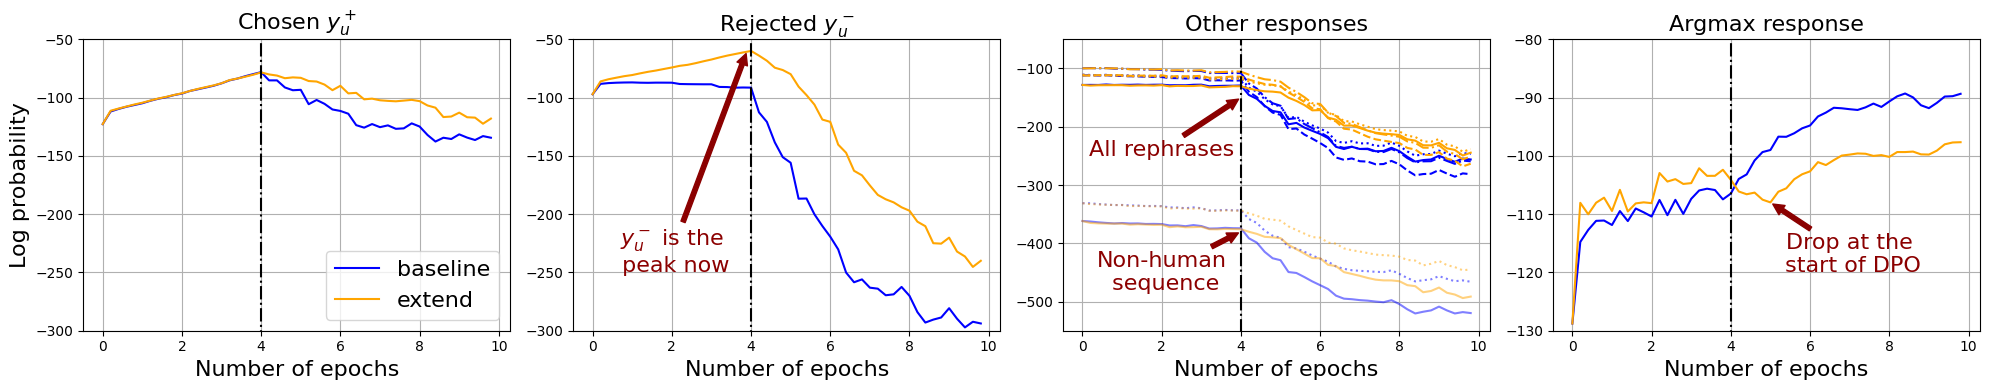

In [135]:
#   Figures
PATH = 'E://P5_5_SFT_dynamics//results_visualize//exp_results_hh'
MODEL_SEQ = [("baseline_sft_qwen18_observe", "baseline_dpo_qwen18_ep6"),
             ("extend_sft_qwen18_observe", "extend_dpo_qwen18_ep6")]
LEGENDS = ['baseline', 'extend']
COLORS = ['blue', 'orange']
OBS_NUM = -1
fig, ax = plt.subplots(1,4,figsize=(20,4))
SMTH = 0.5
for j in range(2):
    file_path = os.path.join(PATH, MODEL_SEQ[j][0], 'prob_train_metrics.json')
    sft_results = read_json_old_exps(file_path)
    file_path = os.path.join(PATH, MODEL_SEQ[j][1], 'prob_train_metrics.json')
    dpo_results = read_json_old_exps(file_path)
    if j==0:
        down_smp = 1
        obs_smp = 20
    else:
        down_smp = 2
        obs_smp = 40
    x_axis = np.arange(0,len(sft_results['chosen'][:obs_smp:down_smp]+dpo_results['chosen']))*100/500
    ax[0].plot(x_axis, sft_results['chosen'][:obs_smp:down_smp] + list(smooth_path(dpo_results['chosen'],SMTH)),  label=LEGENDS[j], color=COLORS[j])
    ax[1].plot(x_axis, sft_results['rejected'][:obs_smp:down_smp] + list(smooth_path(dpo_results['rejected'], SMTH)), label=LEGENDS[j], color=COLORS[j])
    ax[2].plot(x_axis, sft_results['chosen_gptsemantic'][:obs_smp:down_smp] + list(smooth_path(dpo_results['chosen_gptsemantic'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j])
    ax[2].plot(x_axis, sft_results['chosen_gptformat'][:obs_smp:down_smp] + list(smooth_path(dpo_results['chosen_gptformat'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j],linestyle='dotted')
    ax[2].plot(x_axis, sft_results['reject_gptsemantic'][:obs_smp:down_smp] + list(smooth_path(dpo_results['reject_gptsemantic'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j],linestyle='dashed')
    ax[2].plot(x_axis, sft_results['reject_gptformat'][:obs_smp:down_smp] + list(smooth_path(dpo_results['reject_gptformat'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j],linestyle='dashdot')
    ax[2].plot(x_axis, sft_results['random_permute'][:obs_smp:down_smp] + list(smooth_path(dpo_results['random_permute'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j],alpha=0.5)
    ax[2].plot(x_axis, sft_results['random_nonhum'][:obs_smp:down_smp] + list(smooth_path(dpo_results['random_nonhum'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j],alpha=0.5,linestyle='dotted')
    
    ax[3].plot(x_axis, sft_results['argmax'][:obs_smp:down_smp] + list(smooth_path(dpo_results['argmax'],SMTH)), label=LEGENDS[j], color=COLORS[j])

ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[0].set_ylim(-300,-50)
ax[0].set_title(r'Chosen $y_u^+$',fontsize=16)
ax[0].set_ylabel(r'Log probability',fontsize=16)
ax[0].set_xlabel(r'Number of epochs',fontsize=16)
ax[0].plot([4,4],[0,-800],color='black',linestyle='dashdot')

ax[1].grid(True)
ax[1].set_ylim(-300,-50)
ax[1].set_title(r'Rejected $y_u^-$',fontsize=16)
ax[1].set_xlabel(r'Number of epochs',fontsize=16)
ax[1].plot([4,4],[0,-800],color='black',linestyle='dashdot')
ax[1].annotate(r'$y_u^-$ is the'+ '\n peak now', xy=(3.9, -60), xytext=(2,-250), arrowprops=dict(arrowstyle="simple",color='darkred',),
                  horizontalalignment='center',color='darkred',fontsize=16)


ax[2].grid(True)
ax[2].set_ylim(-550,-50)
ax[2].set_title(r'Other responses',fontsize=16)
ax[2].set_xlabel(r'Number of epochs',fontsize=16)
ax[2].plot([4,4],[0,-800],color='black',linestyle='dashdot')
ax[2].annotate('All rephrases', xy=(4, -150), xytext=(2,-250), arrowprops=dict(arrowstyle="simple",color='darkred',),
                  horizontalalignment='center',color='darkred',fontsize=16)
ax[2].annotate('Non-human\n sequence', xy=(4, -380), xytext=(2,-480), arrowprops=dict(arrowstyle="simple",color='darkred',),
                  horizontalalignment='center',color='darkred',fontsize=16)


ax[3].grid(True)
ax[3].set_title(r'Argmax response',fontsize=16)
ax[3].set_xlabel(r'Number of epochs',fontsize=16)
ax[3].plot([4,4],[0,-800],color='black',linestyle='dashdot')
ax[3].set_ylim(-130,-80)
ax[3].annotate('Drop at the\n start of DPO', xy=(5, -108), xytext=(7,-120), arrowprops=dict(arrowstyle="simple",color='darkred',),
                  horizontalalignment='center',color='darkred',fontsize=16)

plt.tight_layout()
# save_name = os.path.join('figures','app_proposed_experiments.pdf')
# plt.savefig(save_name)

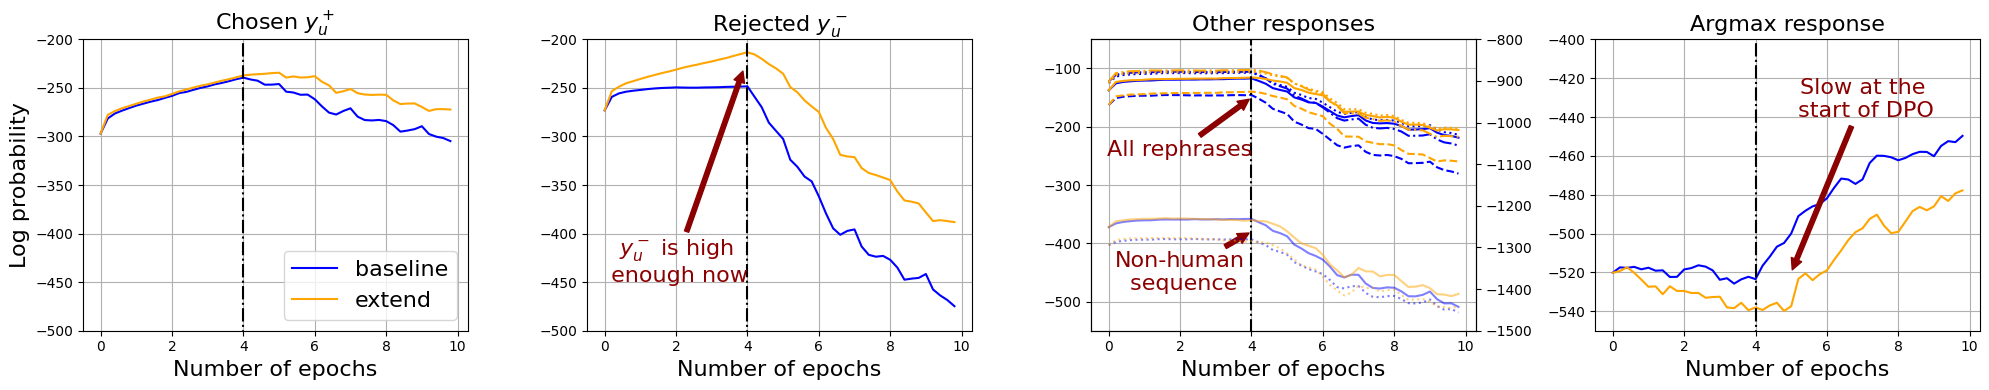

In [6]:
#   Figures
PATH = 'E://P5_5_SFT_dynamics//results_visualize//exp_results_ultrafb'
MODEL_SEQ = [("ultrafb_baseline_sftep2_qwen18", "ultrafb_baseline_dpo_qwen18"),
             ("ultrafb_extend_sftep4_qwen18", "ultrafb_extend_dpo_qwen18_sftep4")]
LEGENDS = ['baseline', 'extend']
COLORS = ['blue', 'orange']
OBS_NUM = -1
X_INTERVAL = 100
fig, ax = plt.subplots(1,4,figsize=(20,4))
SMTH = 0.5
axxx = ax[2].twinx()
for j in range(2):
    file_path = os.path.join(PATH, MODEL_SEQ[j][0], 'prob_train_metrics.json')
    sft_results = read_json_old_exps(file_path)
    file_path = os.path.join(PATH, MODEL_SEQ[j][1], 'prob_train_metrics.json')
    dpo_results = read_json_old_exps(file_path)
    if j==0:
        down_smp = 1
        obs_smp = 20
    else:
        down_smp = 2
        obs_smp = 40
    x_axis = np.arange(0,len(sft_results['chosen'][:obs_smp:down_smp]+dpo_results['chosen']))*X_INTERVAL/500
    ax[0].plot(x_axis, sft_results['chosen'][:obs_smp:down_smp] + list(smooth_path(dpo_results['chosen'],SMTH)),  label=LEGENDS[j], color=COLORS[j])
    ax[1].plot(x_axis, sft_results['rejected'][:obs_smp:down_smp] + list(smooth_path(dpo_results['rejected'], SMTH)), label=LEGENDS[j], color=COLORS[j])
    ax[2].plot(x_axis, sft_results['chosen_gptsemantic'][:obs_smp:down_smp] + list(smooth_path(dpo_results['chosen_gptsemantic'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j])
    ax[2].plot(x_axis, sft_results['chosen_gptformat'][:obs_smp:down_smp] + list(smooth_path(dpo_results['chosen_gptformat'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j],linestyle='dotted')
    ax[2].plot(x_axis, sft_results['reject_gptsemantic'][:obs_smp:down_smp] + list(smooth_path(dpo_results['reject_gptsemantic'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j],linestyle='dashed')
    ax[2].plot(x_axis, sft_results['reject_gptformat'][:obs_smp:down_smp] + list(smooth_path(dpo_results['reject_gptformat'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j],linestyle='dashdot')
    
    axxx.plot(x_axis, sft_results['random_permute'][:obs_smp:down_smp] + list(smooth_path(dpo_results['random_permute'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j],alpha=0.5)
    axxx.plot(x_axis, sft_results['random_nonhum'][:obs_smp:down_smp] + list(smooth_path(dpo_results['random_nonhum'],SMTH)), 
              label=LEGENDS[j], color=COLORS[j],alpha=0.5,linestyle='dotted')
    
    ax[3].plot(x_axis, sft_results['argmax'][:obs_smp:down_smp] + list(smooth_path(dpo_results['argmax'],SMTH)), label=LEGENDS[j], color=COLORS[j])

ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[0].set_ylim(-500,-200)
ax[0].set_title(r'Chosen $y_u^+$',fontsize=16)
ax[0].set_ylabel(r'Log probability',fontsize=16)
ax[0].set_xlabel(r'Number of epochs',fontsize=16)
ax[0].plot([4,4],[0,-800],color='black',linestyle='dashdot')

ax[1].grid(True)
ax[1].set_ylim(-500,-200)
ax[1].set_title(r'Rejected $y_u^-$',fontsize=16)
ax[1].set_xlabel(r'Number of epochs',fontsize=16)
ax[1].plot([4,4],[0,-800],color='black',linestyle='dashdot')
ax[1].annotate(r'$y_u^-$ is high'+ '\n enough now', xy=(3.9, -230), xytext=(2,-450), arrowprops=dict(arrowstyle="simple",color='darkred',),
                  horizontalalignment='center',color='darkred',fontsize=16)


ax[2].grid(True)
ax[2].set_ylim(-550,-50)
axxx.set_ylim(-1500,-800)
ax[2].set_title(r'Other responses',fontsize=16)
ax[2].set_xlabel(r'Number of epochs',fontsize=16)
ax[2].plot([4,4],[0,-800],color='black',linestyle='dashdot')
ax[2].annotate('All rephrases', xy=(4, -150), xytext=(2,-250), arrowprops=dict(arrowstyle="simple",color='darkred',),
                  horizontalalignment='center',color='darkred',fontsize=16)
ax[2].annotate('Non-human\n sequence', xy=(4, -380), xytext=(2,-480), arrowprops=dict(arrowstyle="simple",color='darkred',),
                  horizontalalignment='center',color='darkred',fontsize=16)


ax[3].grid(True)
ax[3].set_title(r'Argmax response',fontsize=16)
ax[3].set_xlabel(r'Number of epochs',fontsize=16)
ax[3].plot([4,4],[0,-800],color='black',linestyle='dashdot')
ax[3].set_ylim(-550,-400)
ax[3].annotate('Slow at the\n start of DPO', xy=(5, -520), xytext=(7,-440), arrowprops=dict(arrowstyle="simple",color='darkred',),
                  horizontalalignment='center',color='darkred',fontsize=16)

plt.tight_layout()
save_name = os.path.join('figures','app_proposed_experiments_fb.pdf')
plt.savefig(save_name)

In [2]:
GEN_PATH = 'E://P5_5_SFT_dynamics//finetuning_dynamics//data//helpful-base//methods_compare'
def extrac_dict(exp_name):
    response_dict = {"prompt":[], "response":[]}
    with open(os.path.join(GEN_PATH, exp_name, 'prob_test_gen_response.jsonl'), 'r') as f:
        for line in f:
            prompt = json.loads(line)['prompt'].strip('\n')
            tmp_response = json.loads(line)['response'].strip('\n')
            if prompt in tmp_response:
                response = tmp_response.split(prompt)[1].strip(' ')
            else:
                response = tmp_response.split('Assistant: ')[1]
            response_dict["prompt"].append(prompt)
            response_dict["response"].append(response)
    return response_dict

def extrac_too_long(exp_all, length=2000):
    rep_list = []
    length_list = []
    for i in range(len(exp_all['response'])):
        length_list.append(len(exp_all['response'][i]))
        if len(exp_all['response'][i])>length:
            rep_list.append(exp_all['response'][i])
    return rep_list, length_list

In [41]:
TOO_LONG = 2000
ext_all = extrac_dict(exp_name='extend_dpo_qwen18_ep6')   # extend_sft_qwen18   extend_dpo_qwen18_ep6
ext_longres, ext_l = extrac_too_long(ext_all, length=TOO_LONG)
print('EXT: Mean length is %2f, too long is %d'%(np.mean(ext_l), len(ext_longres)))

base_all = extrac_dict(exp_name='baseline_dpo_qwen18_ep6')  # baseline_sft_qwen18   baseline_dpo_qwen18_ep6
base_longres, base_l = extrac_too_long(base_all, length=TOO_LONG)
print('BASE:Mean length is %2f, too long is %d'%(np.mean(base_l), len(base_longres)))

EXT: Mean length is 484.518000, too long is 7
BASE:Mean length is 470.744000, too long is 7
